In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/grocery-sales-dataset/countries.csv
/kaggle/input/grocery-sales-dataset/products.csv
/kaggle/input/grocery-sales-dataset/categories.csv
/kaggle/input/grocery-sales-dataset/cities.csv
/kaggle/input/grocery-sales-dataset/employees.csv
/kaggle/input/grocery-sales-dataset/sales.csv
/kaggle/input/grocery-sales-dataset/customers.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense





2025-05-29 16:21:02.383147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748535662.676553      69 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748535662.758105      69 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load CSVs
categories = pd.read_csv('/kaggle/input/grocery-sales-dataset/categories.csv')
cities = pd.read_csv('/kaggle/input/grocery-sales-dataset/cities.csv')
countries = pd.read_csv('/kaggle/input/grocery-sales-dataset/countries.csv')
customers = pd.read_csv('/kaggle/input/grocery-sales-dataset/customers.csv')
employees = pd.read_csv('/kaggle/input/grocery-sales-dataset/employees.csv')
products = pd.read_csv('/kaggle/input/grocery-sales-dataset/products.csv')
sales = pd.read_csv('/kaggle/input/grocery-sales-dataset/sales.csv')

In [4]:
sales['SalesDate'] = pd.to_datetime(sales['SalesDate'])


sales['Year'] = sales['SalesDate'].dt.year
sales['Month'] = sales['SalesDate'].dt.month
sales['DayOfWeek'] = sales['SalesDate'].dt.dayofweek  # Monday=0, Sunday=6
sales['WeekdayName'] = sales['SalesDate'].dt.day_name()
sales['YearMonth'] = sales['SalesDate'].dt.to_period('M')
print(sales['SalesDate'].head())
print(sales['SalesDate'].tail())

0   2018-02-05 07:38:25.430
1   2018-02-02 16:03:31.150
2   2018-05-03 19:31:56.880
3   2018-04-07 14:43:55.420
4   2018-02-12 15:37:03.940
Name: SalesDate, dtype: datetime64[ns]
6758120   2018-04-20 22:39:03.150
6758121   2018-01-13 15:08:18.700
6758122   2018-01-18 12:05:16.950
6758123   2018-02-26 08:13:37.850
6758124   2018-04-17 15:26:30.270
Name: SalesDate, dtype: datetime64[ns]


In [5]:

price_lookup = products.set_index('ProductID')['Price']


sales['Price'] = sales['ProductID'].map(price_lookup)


sales['Revenue'] = sales['Quantity'] * sales['Price'] * (1 - sales['Discount'])
print(sales.head())
print (sales.tail())

   SalesID  SalesPersonID  CustomerID  ProductID  Quantity  Discount  \
0        1              6       27039        381         7       0.0   
1        2             16       25011         61         7       0.0   
2        3             13       94024         23        24       0.0   
3        4              8       73966        176        19       0.2   
4        5             10       32653        310         9       0.0   

   TotalPrice               SalesDate     TransactionNumber    Year  Month  \
0         0.0 2018-02-05 07:38:25.430  FQL4S94E4ME1EZFTG42G  2018.0    2.0   
1         0.0 2018-02-02 16:03:31.150  12UGLX40DJ1A5DTFBHB8  2018.0    2.0   
2         0.0 2018-05-03 19:31:56.880  5DT8RCPL87KI5EORO7B0  2018.0    5.0   
3         0.0 2018-04-07 14:43:55.420  R3DR9MLD5NR76VO17ULE  2018.0    4.0   
4         0.0 2018-02-12 15:37:03.940  4BGS0Z5OMAZ8NDAFHHP3  2018.0    2.0   

   DayOfWeek WeekdayName YearMonth    Price     Revenue  
0        0.0      Monday   2018-02  44.2

In [6]:
products = pd.read_csv('/kaggle/input/grocery-sales-dataset/products.csv')  # if available
sales = sales.merge(products[['ProductID', 'ProductName']], on='ProductID', how='left')
top_products = sales['ProductID'].value_counts().head(50).index
filtered_sales = sales[sales['ProductID'].isin(top_products)]
print(filtered_sales)


         SalesID  SalesPersonID  CustomerID  ProductID  Quantity  Discount  \
5              6             13       28663        413         8       0.0   
15            16             16       91867        364        24       0.0   
20            21             16       91382        147        24       0.0   
21            22             18       23677        442         6       0.0   
23            24             23       66030        324        17       0.0   
...          ...            ...         ...        ...       ...       ...   
6758098  6758099             21       30411        425         8       0.1   
6758099  6758100             18       17899        148         5       0.0   
6758100  6758101             18       14921         94         4       0.0   
6758119  6758120             12       37105         94        10       0.0   
6758123  6758124             17       90315        104        23       0.0   

         TotalPrice               SalesDate     TransactionNumb

/tmp/ipykernel_69/1336952459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sales['SalesDate'] = pd.to_datetime(filtered_sales['SalesDate'], errors='coerce')


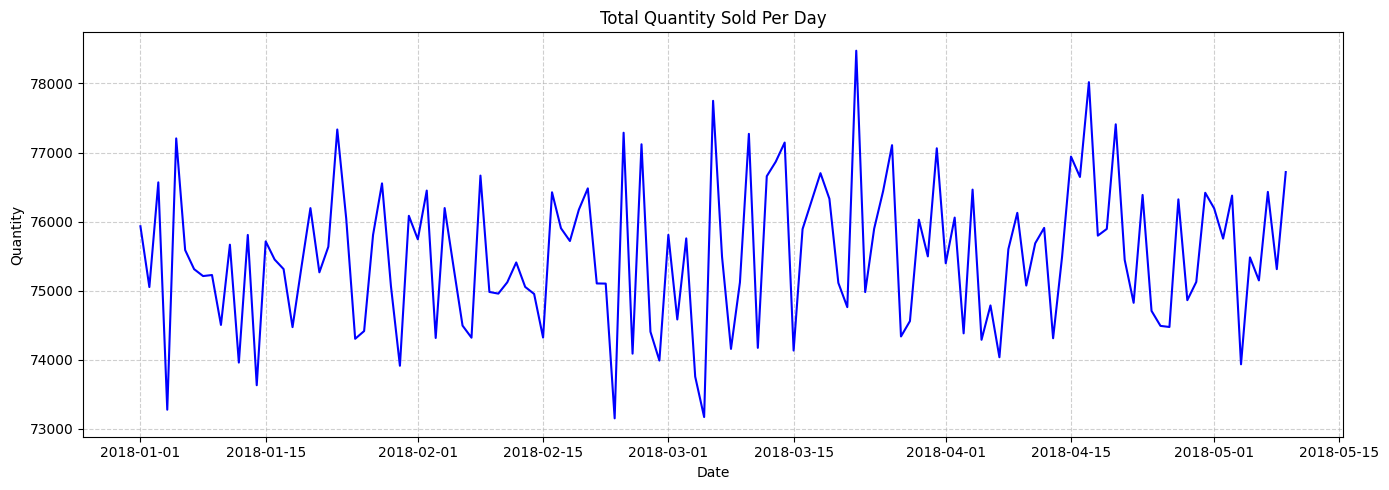

In [7]:
filtered_sales['SalesDate'] = pd.to_datetime(filtered_sales['SalesDate'], errors='coerce')


filtered_sales = filtered_sales.dropna(subset=['SalesDate'])


filtered_sales['SalesDateOnly'] = filtered_sales['SalesDate'].dt.date


daily_sales = (
    filtered_sales.groupby('SalesDateOnly')['Quantity'].sum()
    .asfreq('D')  # this creates a complete daily index
    .fillna(0)    # fill missing days with 0
)


daily_sales.index = pd.to_datetime(daily_sales.index)



plt.figure(figsize=(14, 5))
plt.plot(daily_sales.index, daily_sales, color='blue')
plt.title("Total Quantity Sold Per Day")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [8]:
daily_sales = filtered_sales.groupby('SalesDate')['Quantity'].sum()
print(filtered_sales['SalesDate'].min(), filtered_sales['SalesDate'].max())
print(filtered_sales['SalesDate'].nunique())
print(filtered_sales.head())


2018-01-01 00:00:07.650000 2018-05-09 23:59:21.010000
749503
    SalesID  SalesPersonID  CustomerID  ProductID  Quantity  Discount  \
5         6             13       28663        413         8       0.0   
15       16             16       91867        364        24       0.0   
20       21             16       91382        147        24       0.0   
21       22             18       23677        442         6       0.0   
23       24             23       66030        324        17       0.0   

    TotalPrice               SalesDate     TransactionNumber    Year  Month  \
5          0.0 2018-02-07 10:33:24.990  3KTAYIZPGDQMZMRWZ8NG  2018.0    2.0   
15         0.0 2018-04-30 23:55:11.560  AO360LVKUYJSSGL5T5MF  2018.0    4.0   
20         0.0 2018-04-30 08:42:49.010  7BKSQOA5XQ50L9DLAXUB  2018.0    4.0   
21         0.0 2018-01-31 22:14:45.630  3XJQHRN1HU7295SB6QUL  2018.0    1.0   
23         0.0 2018-03-28 05:56:50.450  FWXXB3LA360PZJJMPCVH  2018.0    3.0   

    DayOfWeek WeekdayName

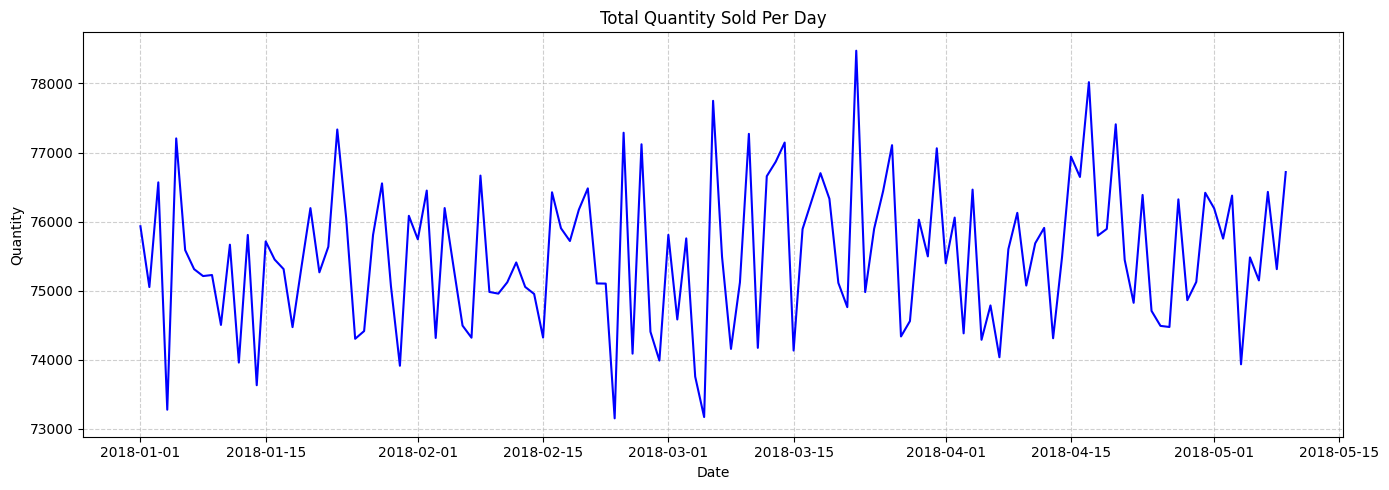

2018-01-01 00:00:07.650000 2018-05-09 23:59:21.010000
749503
    SalesID  SalesPersonID  CustomerID  ProductID  Quantity  Discount  \
5         6             13       28663        413         8       0.0   
15       16             16       91867        364        24       0.0   
20       21             16       91382        147        24       0.0   
21       22             18       23677        442         6       0.0   
23       24             23       66030        324        17       0.0   

    TotalPrice               SalesDate     TransactionNumber    Year  Month  \
5          0.0 2018-02-07 10:33:24.990  3KTAYIZPGDQMZMRWZ8NG  2018.0    2.0   
15         0.0 2018-04-30 23:55:11.560  AO360LVKUYJSSGL5T5MF  2018.0    4.0   
20         0.0 2018-04-30 08:42:49.010  7BKSQOA5XQ50L9DLAXUB  2018.0    4.0   
21         0.0 2018-01-31 22:14:45.630  3XJQHRN1HU7295SB6QUL  2018.0    1.0   
23         0.0 2018-03-28 05:56:50.450  FWXXB3LA360PZJJMPCVH  2018.0    3.0   

    DayOfWeek WeekdayName

In [9]:



filtered_sales['SalesDate'] = pd.to_datetime(filtered_sales['SalesDate'], errors='coerce')
filtered_sales = filtered_sales.dropna(subset=['SalesDate'])


filtered_sales['SalesDateOnly'] = filtered_sales['SalesDate'].dt.normalize()  # keep as datetime


daily_sales = (
    filtered_sales.groupby('SalesDateOnly')['Quantity'].sum()
    .reindex(pd.date_range(filtered_sales['SalesDateOnly'].min(),
                           filtered_sales['SalesDateOnly'].max()), fill_value=0)
)


plt.figure(figsize=(14, 5))
plt.plot(daily_sales.index, daily_sales, color='blue')
plt.title("Total Quantity Sold Per Day")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


print(filtered_sales['SalesDate'].min(), filtered_sales['SalesDate'].max())
print(filtered_sales['SalesDate'].nunique())
print(filtered_sales.head())


print(daily_sales.shape)
print(daily_sales.head())


# ADF

In [10]:
from statsmodels.tsa.stattools import adfuller

weekly_sales = daily_sales.resample('W').sum()


weekly_sales = weekly_sales.dropna()

result = adfuller(weekly_sales)


print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"  {key}: {value}")

ADF Statistic: -3.1925486216004493
p-value: 0.02042006602644866
Critical Values:
  1%: -4.223238279489106
  5%: -3.189368925619835
  10%: -2.729839421487603


# ARIMA

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/tmp/ipykernel_69/110236858.py:40: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()


📄 ARIMA Model Summary:

                               SARIMAX Results                                
Dep. Variable:               Quantity   No. Observations:                  129
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1114.708
Date:                Thu, 29 May 2025   AIC                           2235.417
Time:                        16:21:52   BIC                           2243.973
Sample:                    01-01-2018   HQIC                          2238.893
                         - 05-09-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9833      0.010   -100.216      0.000      -1.002      -0.964
ma.L1          0.9657      0.016     61.385      0.000       0.935       0.997
sigma2      2.049e+06   2.25

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


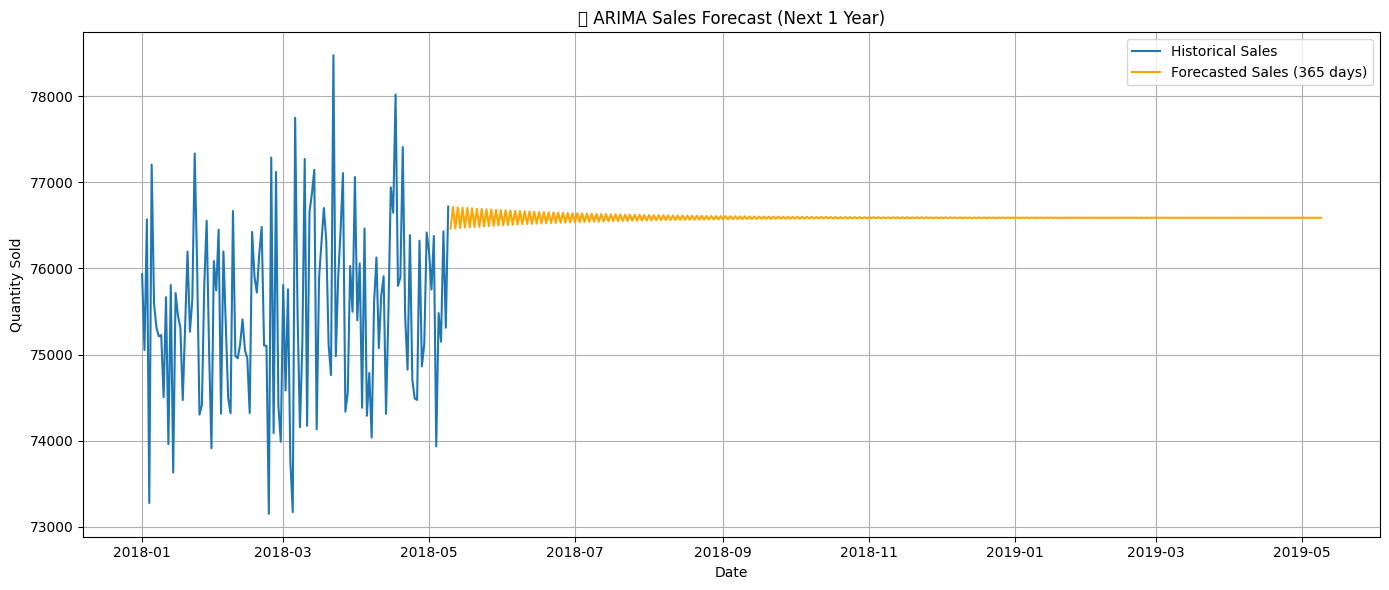


📊 Backtest Evaluation (on last 30 days):
MAE  : 828.74
RMSE : 1009.26
MAPE : 1.10%


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Ensure 'Quantity' Series is extracted correctly ---
if isinstance(daily_sales, pd.DataFrame) and 'Quantity' in daily_sales.columns:
    ts = daily_sales['Quantity']
elif isinstance(daily_sales, pd.Series):
    ts = daily_sales
else:
    raise ValueError("❌ 'daily_sales' must be a Series or a DataFrame with a 'Quantity' column.")

# --- Ensure daily frequency and no missing values ---
ts = ts.asfreq('D').fillna(0)

# --- Fit ARIMA model ---
model = ARIMA(ts, order=(1, 1, 1))  # You can tune this (p,d,q)
fit = model.fit()

# --- Show summary ---
print("📄 ARIMA Model Summary:\n")
print(fit.summary())

# --- Forecast 365 days ahead ---
forecast_steps = 365
forecast = fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=ts.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# --- Plot the full forecast ---
plt.figure(figsize=(14, 6))
plt.plot(ts.index, ts, label='Historical Sales')
plt.plot(forecast_index, forecast, label='Forecasted Sales (365 days)', color='orange')
plt.title("📈 ARIMA Sales Forecast (Next 1 Year)")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# --- Backtest: Evaluate on last 30 days of available data ---
if len(ts) >= 60:
    test_size = 30
    train_bt = ts[:-test_size]
    test_bt = ts[-test_size:]

    bt_model = ARIMA(train_bt, order=(1, 1, 1))
    bt_fit = bt_model.fit()
    bt_forecast = bt_fit.forecast(steps=test_size)
    bt_forecast.index = test_bt.index

    mae = mean_absolute_error(test_bt, bt_forecast)
    rmse = np.sqrt(mean_squared_error(test_bt, bt_forecast))
    mape = np.mean(np.abs((test_bt - bt_forecast) / test_bt.replace(0, np.nan))) * 100

    print("\n📊 Backtest Evaluation (on last 30 days):")
    print(f"MAE  : {mae:.2f}")
    print(f"RMSE : {rmse:.2f}")
    print(f"MAPE : {mape:.2f}%")


In [12]:
print("Average daily sales:", daily_sales.mean())
print("Max daily sales:", daily_sales.max())


Average daily sales: 75512.95348837209
Max daily sales: 78473


# SARIMA

Tested SARIMA(0, 0, 0)x(0, 0, 0, 7) - AIC: 2582.62
Tested SARIMA(0, 0, 0)x(0, 0, 1, 7) - AIC: 2342.66
Tested SARIMA(0, 0, 0)x(0, 1, 0, 7) - AIC: 1665.37
Tested SARIMA(0, 0, 0)x(0, 1, 1, 7) - AIC: 1535.14
Tested SARIMA(0, 0, 0)x(1, 0, 0, 7) - AIC: 1684.04
Tested SARIMA(0, 0, 0)x(1, 0, 1, 7) - AIC: 1672.03
Tested SARIMA(0, 0, 0)x(1, 1, 0, 7) - AIC: 1539.25
Tested SARIMA(0, 0, 0)x(1, 1, 1, 7) - AIC: 1525.09
Tested SARIMA(0, 0, 1)x(0, 0, 0, 7) - AIC: 2486.31
Tested SARIMA(0, 0, 1)x(0, 0, 1, 7) - AIC: 2300.73
Tested SARIMA(0, 0, 1)x(0, 1, 0, 7) - AIC: 1641.95
Tested SARIMA(0, 0, 1)x(0, 1, 1, 7) - AIC: 1516.60
Tested SARIMA(0, 0, 1)x(1, 0, 0, 7) - AIC: 2338.89
Tested SARIMA(0, 0, 1)x(1, 0, 1, 7) - AIC: 2292.29
Tested SARIMA(0, 0, 1)x(1, 1, 0, 7) - AIC: 1541.00
Tested SARIMA(0, 0, 1)x(1, 1, 1, 7) - AIC: 1509.91
Tested SARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC: 1787.27
Tested SARIMA(0, 1, 0)x(0, 0, 1, 7) - AIC: 1660.80
Tested SARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC: 1736.59
Tested SARIMA(0, 1, 0)x(0, 1, 1

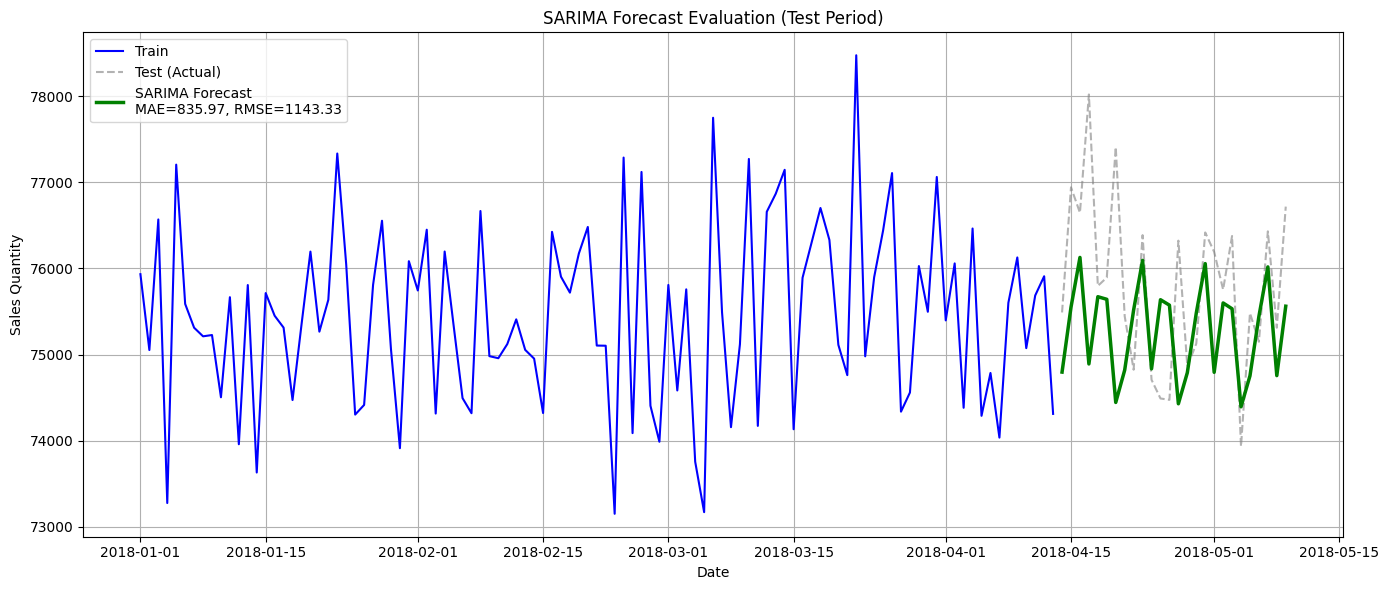

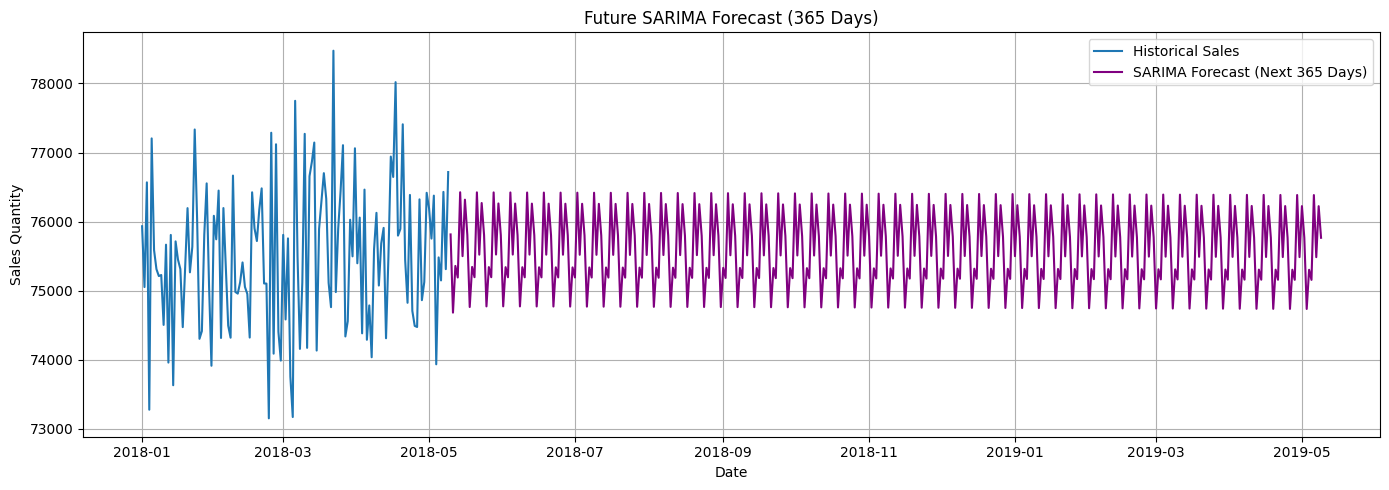

In [13]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


daily_sales = daily_sales.asfreq('D').fillna(0)


train_size = int(len(daily_sales) * 0.8)
train = daily_sales[:train_size]
test = daily_sales[train_size:]


p = d = q = range(0, 2)
seasonal_p = seasonal_d = seasonal_q = range(0, 2)
seasonal_period = 7  

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(seasonal_p, seasonal_d, seasonal_q, [seasonal_period]))


best_aic = float("inf")
best_order = None
best_seasonal_order = None

warnings.filterwarnings("ignore")

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(
                train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            result = model.fit(disp=False)
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = order
                best_seasonal_order = seasonal_order
            print(f"Tested SARIMA{order}x{seasonal_order} - AIC: {result.aic:.2f}")
        except Exception as e:
            print(f"Error with SARIMA{order}x{seasonal_order}: {e}")
            continue

print("\n✅ Best SARIMA configuration found:")
print(f"Order: {best_order}")
print(f"Seasonal Order: {best_seasonal_order}")
print(f"Best AIC: {best_aic:.2f}")


best_model = SARIMAX(
    train,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
best_result = best_model.fit()


forecast_test = best_result.forecast(steps=len(test))
forecast_test.index = test.index  # Align index


mae = mean_absolute_error(test, forecast_test)
rmse = np.sqrt(mean_squared_error(test, forecast_test))
print(f"\n📊 MAE: {mae:.2f}")
print(f"📊 RMSE: {rmse:.2f}")
print(f"📊 MAPE: {mape:.2f}")

#plot
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Train', color='blue')
plt.plot(test.index, test, label='Test (Actual)', color='gray', linestyle='--', alpha=0.6)
plt.plot(forecast_test.index, forecast_test, label=f'SARIMA Forecast\nMAE={mae:.2f}, RMSE={rmse:.2f}', color='green', linewidth=2.5)
plt.title("SARIMA Forecast Evaluation (Test Period)")
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


future_model = SARIMAX(
    daily_sales,  # full data
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
future_result = future_model.fit()
future_forecast = future_result.forecast(steps=365)
future_index = pd.date_range(start=daily_sales.index[-1] + pd.Timedelta(days=1), periods=365)


plt.figure(figsize=(14, 5))
plt.plot(daily_sales.index, daily_sales, label='Historical Sales')
plt.plot(future_index, future_forecast, label='SARIMA Forecast (Next 365 Days)', color='purple')
plt.title("Future SARIMA Forecast (365 Days)")
plt.xlabel("Date")
plt.ylabel("Sales Quantity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# effects on price 

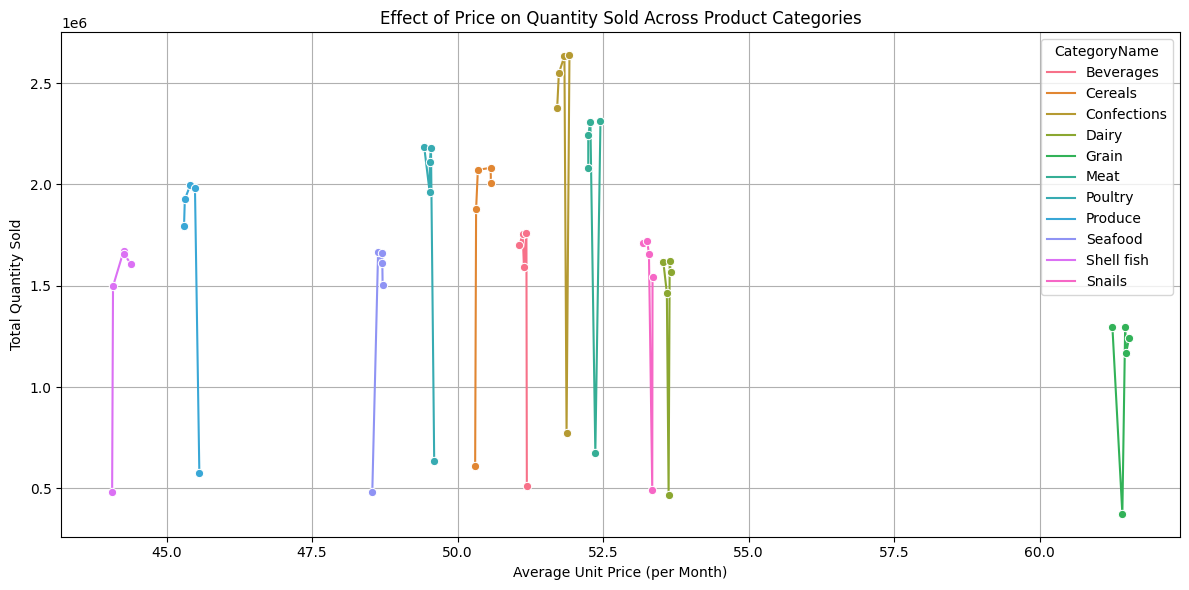

Correlation Between Price and Quantity by Category:
   CategoryName  Price-Quantity Correlation
6       Poultry                   -0.713959
7       Produce                   -0.661759
10       Snails                   -0.596161
0     Beverages                   -0.531361
2   Confections                   -0.246697
5          Meat                   -0.221463
3         Dairy                   -0.150680
4         Grain                   -0.009609
1       Cereals                    0.542994
9    Shell fish                    0.661312
8       Seafood                    0.871770


In [14]:



sales['SalesDate'] = pd.to_datetime(sales['SalesDate'], errors='coerce')
sales.dropna(subset=['SalesDate'], inplace=True)
sales['Month'] = sales['SalesDate'].dt.to_period('M').astype(str)

#  Rename price column
products = products.rename(columns={'Price': 'UnitPrice'})

# Merge sales with products and categories
merged = sales.merge(products[['ProductID', 'UnitPrice', 'CategoryID']], on='ProductID', how='left')
merged = merged.merge(categories[['CategoryID', 'CategoryName']], on='CategoryID', how='left')


category_monthly = merged.groupby(['CategoryName', 'Month']).agg({
    'UnitPrice': 'mean',
    'Quantity': 'sum'
}).reset_index()

#  Plot price vs quantity
plt.figure(figsize=(12, 6))
sns.lineplot(data=category_monthly, x='UnitPrice', y='Quantity', hue='CategoryName', marker='o')
plt.title('Effect of Price on Quantity Sold Across Product Categories')
plt.xlabel('Average Unit Price (per Month)')
plt.ylabel('Total Quantity Sold')
plt.grid(True)
plt.tight_layout()
plt.show()

#  Correlation analysis
correlation_df = category_monthly.groupby('CategoryName').apply(
    lambda df: df['UnitPrice'].corr(df['Quantity'])
).reset_index(name='Price-Quantity Correlation')

print("Correlation Between Price and Quantity by Category:")
print(correlation_df.sort_values(by='Price-Quantity Correlation'))


# k means  clustering 

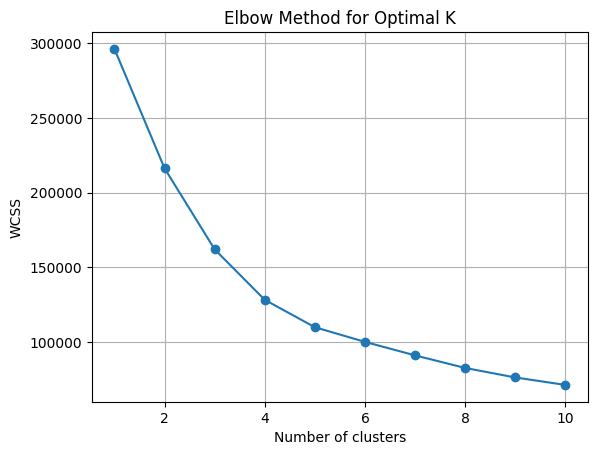

RFM Cluster Summary:
   Cluster   Recency  Frequency      Monetary  NumCustomers
0        0  1.966925  59.801454  34852.111183         30809
1        1  1.939226  72.360725  70728.155377         30605
2        2  1.876469  73.062716  23061.547121         26293
3        3  6.561980  64.471408  40218.121604         11052


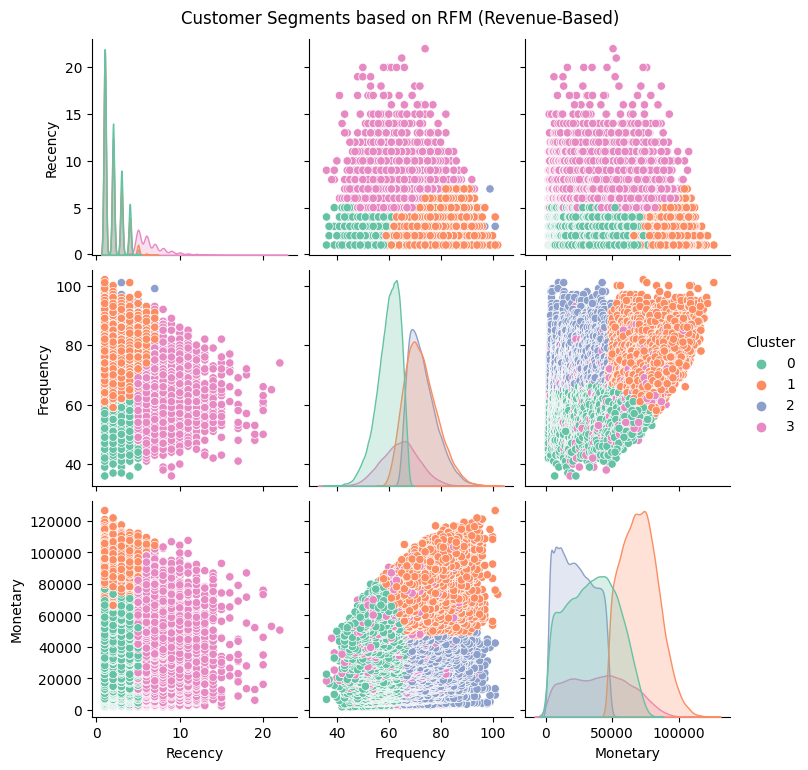

In [15]:


sales['SalesDate'] = pd.to_datetime(sales['SalesDate'])


assert all(col in sales.columns for col in ['CustomerID', 'SalesDate', 'SalesID', 'Revenue']), \
    "Missing required columns in the sales data"


reference_date = sales['SalesDate'].max() + pd.Timedelta(days=1)

# RFM calculation 
rfm = sales.groupby('CustomerID').agg({
    'SalesDate': lambda x: (reference_date - x.max()).days,   # Recency
    'SalesID': 'count',                                       # Frequency
    'Revenue': 'sum'                                          # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'NumCustomers'}).reset_index()

print("RFM Cluster Summary:")
print(cluster_summary)


sns.pairplot(rfm, hue='Cluster', vars=['Recency', 'Frequency', 'Monetary'], palette='Set2')
plt.suptitle("Customer Segments based on RFM (Revenue-Based)", y=1.02)
plt.show()


# promotional impact

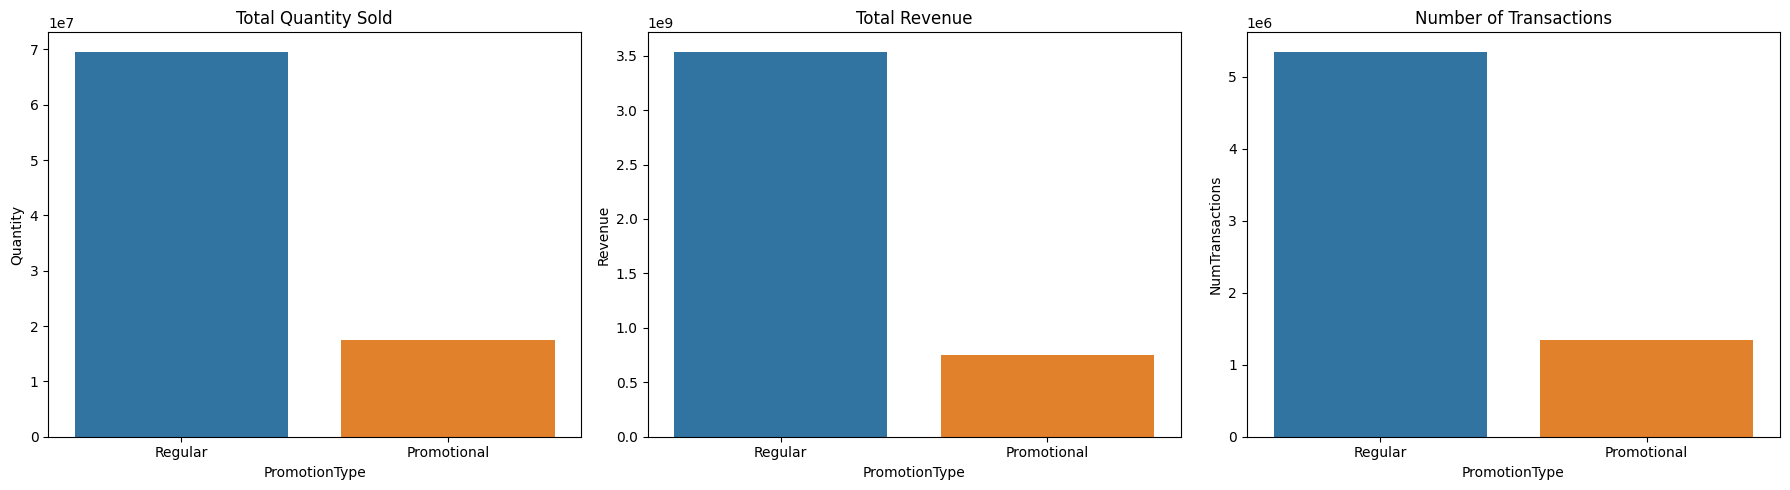

Promotional Impact Summary:
  PromotionType  Quantity       Revenue  NumTransactions
0       Regular  69599247  3.537713e+09          5353035
1   Promotional  17404300  7.515288e+08          1337564


In [16]:



sales['Discount'] = sales['Discount'].fillna(0)


sales['IsPromotional'] = sales['Discount'] > 0


promo_summary = sales.groupby('IsPromotional').agg({
    'Quantity': 'sum',
    'Revenue': 'sum',
    'SalesID': 'count'
}).rename(columns={'SalesID': 'NumTransactions'}).reset_index()


promo_summary['PromotionType'] = promo_summary['IsPromotional'].map({True: 'Promotional', False: 'Regular'})


fig, axes = plt.subplots(1, 3, figsize=(18, 5))


sns.barplot(data=promo_summary, x='PromotionType', y='Quantity', ax=axes[0])
axes[0].set_title("Total Quantity Sold")


sns.barplot(data=promo_summary, x='PromotionType', y='Revenue', ax=axes[1])
axes[1].set_title("Total Revenue")

sns.barplot(data=promo_summary, x='PromotionType', y='NumTransactions', ax=axes[2])
axes[2].set_title("Number of Transactions")

plt.tight_layout()
plt.show()


print("Promotional Impact Summary:")
print(promo_summary[['PromotionType', 'Quantity', 'Revenue', 'NumTransactions']])


# revenue and gross profit share

In [17]:
print(sales.columns.tolist())


['SalesID', 'SalesPersonID', 'CustomerID', 'ProductID', 'Quantity', 'Discount', 'TotalPrice', 'SalesDate', 'TransactionNumber', 'Year', 'Month', 'DayOfWeek', 'WeekdayName', 'YearMonth', 'Price', 'Revenue', 'ProductName', 'IsPromotional']


<Figure size 1200x600 with 0 Axes>

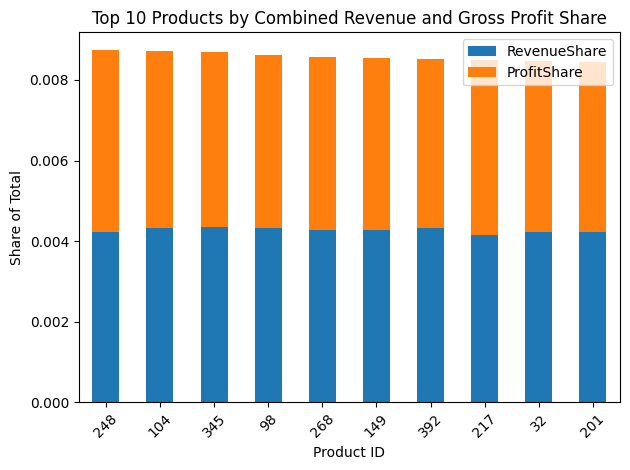

Top 10 Products by Revenue + Profit Share:
     ProductID       Revenue   GrossProfit  RevenueShare  ProfitShare
247        248  1.814032e+07  598349.12285      0.004229     0.004517
103        104  1.849728e+07  584963.23340      0.004312     0.004416
344        345  1.870282e+07  573937.79380      0.004360     0.004333
97          98  1.852235e+07  569450.15080      0.004318     0.004299
267        268  1.833395e+07  569410.03260      0.004274     0.004298
148        149  1.836801e+07  564132.08692      0.004282     0.004259
391        392  1.852197e+07  555265.44918      0.004318     0.004192
216        217  1.784126e+07  574371.21600      0.004160     0.004336
31          32  1.812727e+07  563387.61245      0.004226     0.004253
200        201  1.815287e+07  558563.24450      0.004232     0.004217


In [18]:



assert all(col in sales.columns for col in ['ProductID', 'Quantity', 'Revenue', 'Price']), \
    "Missing one or more required columns: 'ProductID', 'Quantity', 'Revenue', 'Price'"

# Calculate Gross Profit 
sales['GrossProfit'] = (sales['Price'] * sales['Quantity']) - sales['Revenue']


product_summary = sales.groupby('ProductID').agg({
    'Revenue': 'sum',
    'GrossProfit': 'sum',
    'Quantity': 'sum'
}).reset_index()

#  Calculate share of total revenue and gross profit
total_revenue = product_summary['Revenue'].sum()
total_profit = product_summary['GrossProfit'].sum()

product_summary['RevenueShare'] = product_summary['Revenue'] / total_revenue
product_summary['ProfitShare'] = product_summary['GrossProfit'] / total_profit

#  Calculate combined share (Revenue + Profit)
product_summary['CombinedShare'] = product_summary['RevenueShare'] + product_summary['ProfitShare']

#  Sort by combined share and get top 10 products
top_products = product_summary.sort_values(by='CombinedShare', ascending=False).head(10)


plt.figure(figsize=(12, 6))
top_plot = top_products.set_index('ProductID')[['RevenueShare', 'ProfitShare']].plot(kind='bar', stacked=True)
plt.title('Top 10 Products by Combined Revenue and Gross Profit Share')
plt.ylabel('Share of Total')
plt.xlabel('Product ID')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


print("Top 10 Products by Revenue + Profit Share:")
print(top_products[['ProductID', 'Revenue', 'GrossProfit', 'RevenueShare', 'ProfitShare']])


# Average spending by progarm

count    6.690599e+06
mean     6.410849e+02
std      5.470785e+02
min      3.592000e-02
25%      1.806483e+02
50%      4.907658e+02
75%      9.837400e+02
max      2.496888e+03
Name: Revenue, dtype: float64
IsLoyaltyMember
False    4611232
True     2079367
Name: count, dtype: int64


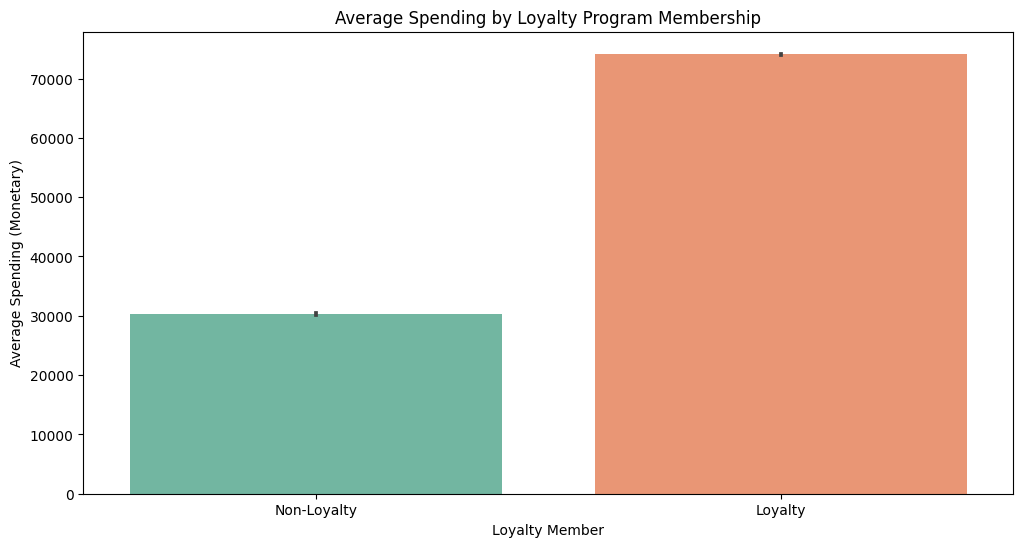

Average Spending by Loyalty Status:
   IsLoyaltyMember      Monetary  Frequency
0            False  30302.593842  66.702811
1             True  74064.844481  70.182496


In [19]:



print(sales['Revenue'].describe())


loyalty_threshold = sales.groupby('CustomerID')['Revenue'].sum().quantile(0.7)
sales['IsLoyaltyMember'] = sales.groupby('CustomerID')['Revenue'].transform('sum') > loyalty_threshold


print(sales['IsLoyaltyMember'].value_counts())


assert all(col in sales.columns for col in ['CustomerID', 'IsLoyaltyMember', 'Revenue', 'SalesDate']), \
    "Missing one or more required columns: 'CustomerID', 'IsLoyaltyMember', 'Revenue', 'SalesDate'"


reference_date = sales['SalesDate'].max() + pd.Timedelta(days=1)

rfm = sales.groupby('CustomerID').agg({
    'SalesDate': lambda x: (reference_date - x.max()).days,   # Recency
    'Revenue': 'sum',                                        # Monetary (Revenue)
    'SalesID': 'count'                                        # Frequency
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Monetary', 'Frequency']


rfm = pd.merge(rfm, sales[['CustomerID', 'IsLoyaltyMember']].drop_duplicates(), on='CustomerID', how='left')

# Step 4: Calculate average spending for loyalty vs non-loyalty members
loyalty_spending = rfm.groupby('IsLoyaltyMember').agg({
    'Monetary': 'mean',
    'Frequency': 'mean'
}).reset_index()


attrition_period = 180  # 6 months
recent_customers = sales[sales['SalesDate'] >= reference_date - pd.Timedelta(days=attrition_period)]
active_customers = recent_customers['CustomerID'].unique()


rfm['Attrition'] = np.where(rfm['CustomerID'].isin(active_customers), 0, 1)  # 0 = Active, 1 = Attrited
attrition_rate = rfm.groupby('IsLoyaltyMember')['Attrition'].mean()


plt.figure(figsize=(12, 6))

# Average Spending Comparison 
sns.barplot(x='IsLoyaltyMember', y='Monetary', data=rfm, palette='Set2')
plt.title('Average Spending by Loyalty Program Membership')
plt.xlabel('Loyalty Member')
plt.ylabel('Average Spending (Monetary)')
plt.xticks([0, 1], ['Non-Loyalty', 'Loyalty'])
plt.show()




print("Average Spending by Loyalty Status:")
print(loyalty_spending)




In [20]:
print(sales.columns)


Index(['SalesID', 'SalesPersonID', 'CustomerID', 'ProductID', 'Quantity',
       'Discount', 'TotalPrice', 'SalesDate', 'TransactionNumber', 'Year',
       'Month', 'DayOfWeek', 'WeekdayName', 'YearMonth', 'Price', 'Revenue',
       'ProductName', 'IsPromotional', 'GrossProfit', 'IsLoyaltyMember'],
      dtype='object')


# Arima vs Lstm

2025-05-29 16:23:35.579627: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.3541
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.2240
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.1275
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0606
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0675
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0785
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0628
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0475
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0543
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0584


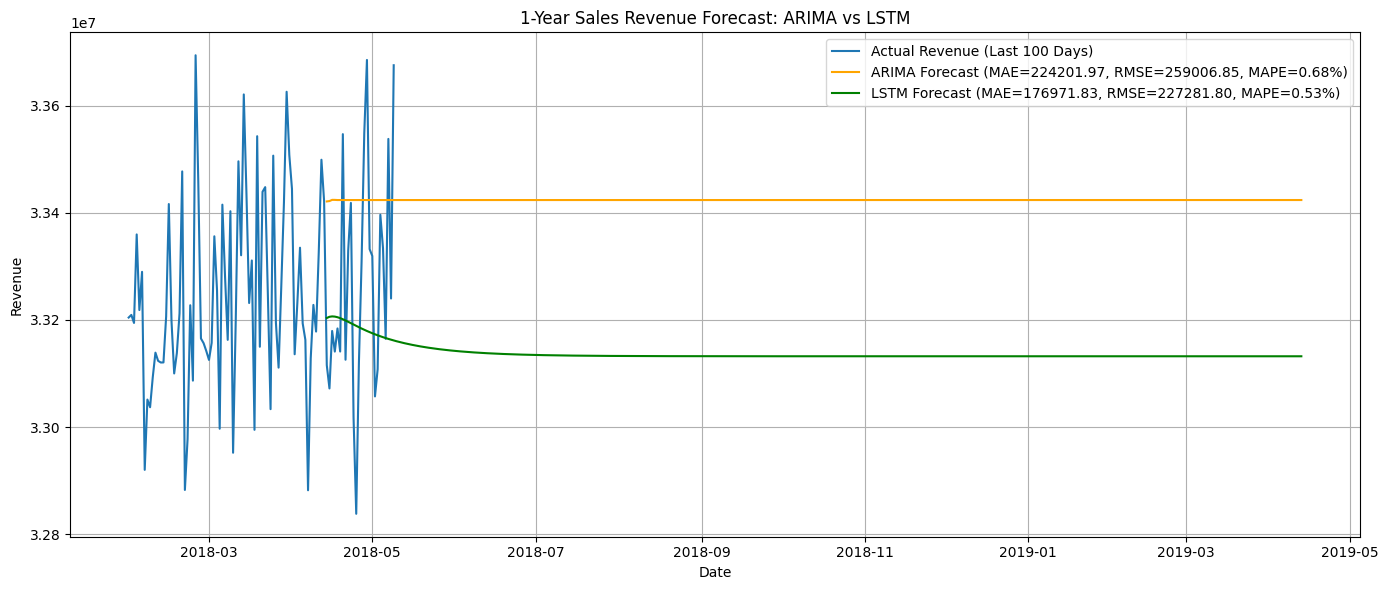

In [21]:


sales['SalesDate'] = pd.to_datetime(sales['SalesDate'])


sales.set_index('SalesDate', inplace=True)
daily_revenue = sales['Revenue'].resample('D').sum().fillna(0)

# Train/test split (80% train, 20% test)
train_size = int(len(daily_revenue) * 0.8)
train_data = daily_revenue[:train_size]
test_data = daily_revenue[train_size:train_size + 365]  # Use up to 1 year of test data if available

# --- ARIMA Model ---
arima_model = ARIMA(train_data, order=(5, 1, 0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=365)

# --- LSTM Model ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Create sequences
X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Build and train LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=10, batch_size=32, verbose=1)

# Forecast next 365 days
lstm_forecast = []
lstm_input = scaled_data[-60:].reshape(1, 60, 1)

for _ in range(365):
    next_pred = model.predict(lstm_input, verbose=0)
    lstm_forecast.append(next_pred[0, 0])
    next_pred_reshaped = next_pred.reshape(1, 1, 1)
    lstm_input = np.concatenate((lstm_input[:, 1:, :], next_pred_reshaped), axis=1)


lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1))

# --- Evaluation ---
def evaluate_forecast(true_values, predicted_values):
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
    mape = np.mean(np.abs((true_values - predicted_values) / true_values.replace(0, np.nan))) * 100
    return mae, rmse, mape


test_data_eval = test_data[:365]
common_index = test_data_eval.index.intersection(arima_forecast.index)


arima_eval = arima_forecast.loc[common_index]
true_eval = test_data_eval.loc[common_index]
arima_mae, arima_rmse, arima_mape = evaluate_forecast(true_eval, arima_eval)


lstm_index = pd.date_range(start=train_data.index[-1] + pd.Timedelta(days=1), periods=365)
lstm_eval = pd.Series(lstm_forecast.flatten(), index=lstm_index)
common_index_lstm = test_data_eval.index.intersection(lstm_eval.index)
lstm_eval = lstm_eval.loc[common_index_lstm]
true_eval_lstm = test_data_eval.loc[common_index_lstm]
lstm_mae, lstm_rmse, lstm_mape = evaluate_forecast(true_eval_lstm, lstm_eval)

# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(daily_revenue.index[-100:], daily_revenue.values[-100:], label='Actual Revenue (Last 100 Days)')
plt.plot(arima_forecast.index, arima_forecast, label=f'ARIMA Forecast (MAE={arima_mae:.2f}, RMSE={arima_rmse:.2f}, MAPE={arima_mape:.2f}%)', color='orange')
plt.plot(lstm_index, lstm_forecast.flatten(), label=f'LSTM Forecast (MAE={lstm_mae:.2f}, RMSE={lstm_rmse:.2f}, MAPE={lstm_mape:.2f}%)', color='green')
plt.title('1-Year Sales Revenue Forecast: ARIMA vs LSTM')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# demographic and avg revenue 

In [22]:



customer_location = customers.merge(cities[['CityID', 'CityName', 'CountryID']], on='CityID', how='left')
customer_location = customer_location.merge(countries[['CountryID', 'CountryName']], on='CountryID', how='left')


customer_behavior = sales.groupby('CustomerID').agg({
    'TransactionNumber': 'nunique',    # Frequency
    'Quantity': 'sum',                 # Total quantity
    'Revenue': 'sum'                   # Total revenue spent
}).rename(columns={
    'TransactionNumber': 'Frequency',
    'Quantity': 'TotalQuantity',
    'Revenue': 'TotalRevenue'
}).reset_index()


customer_summary = customer_behavior.merge(customer_location, on='CustomerID', how='left')


geo_behavior = customer_summary.groupby(['CountryName', 'CityName']).agg({
    'CustomerID': 'nunique',
    'Frequency': 'mean',
    'TotalQuantity': 'mean',
    'TotalRevenue': 'mean'
}).rename(columns={
    'CustomerID': 'NumCustomers',
    'Frequency': 'AvgFrequency',
    'TotalQuantity': 'AvgQuantity',
    'TotalRevenue': 'AvgRevenue'
}).reset_index()


geo_behavior = geo_behavior.sort_values(by='AvgRevenue', ascending=False)

print(geo_behavior.head(10))  


      CountryName      CityName  NumCustomers  AvgFrequency  AvgQuantity  \
39  United States       Jackson          1065     67.396244   907.962441   
75  United States   San Antonio          1038     68.265896   910.298651   
40  United States  Jacksonville          1006     68.265408   912.179920   
1   United States   Albuquerque          1028     67.911479   904.588521   
49  United States       Lubbock           993     67.929507   901.729104   
17  United States     Cleveland           996     67.807229   902.997992   
60  United States      New York          1034     67.618956   900.649903   
4   United States     Arlington          1031     67.285160   899.938894   
8   United States   Bakersfield           993     67.797583   900.283988   
34  United States    Greensboro          1036     67.610039   898.337838   

      AvgRevenue  
39  44995.751649  
75  44918.524888  
40  44887.653282  
1   44717.733172  
49  44712.622857  
17  44522.472256  
60  44468.548992  
4   44450.3

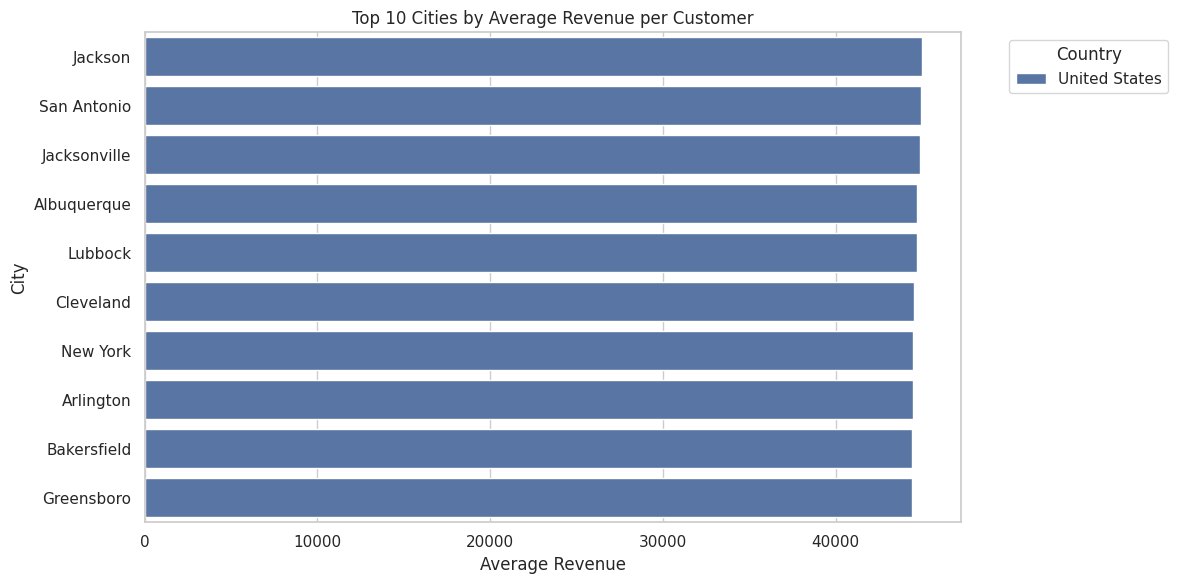

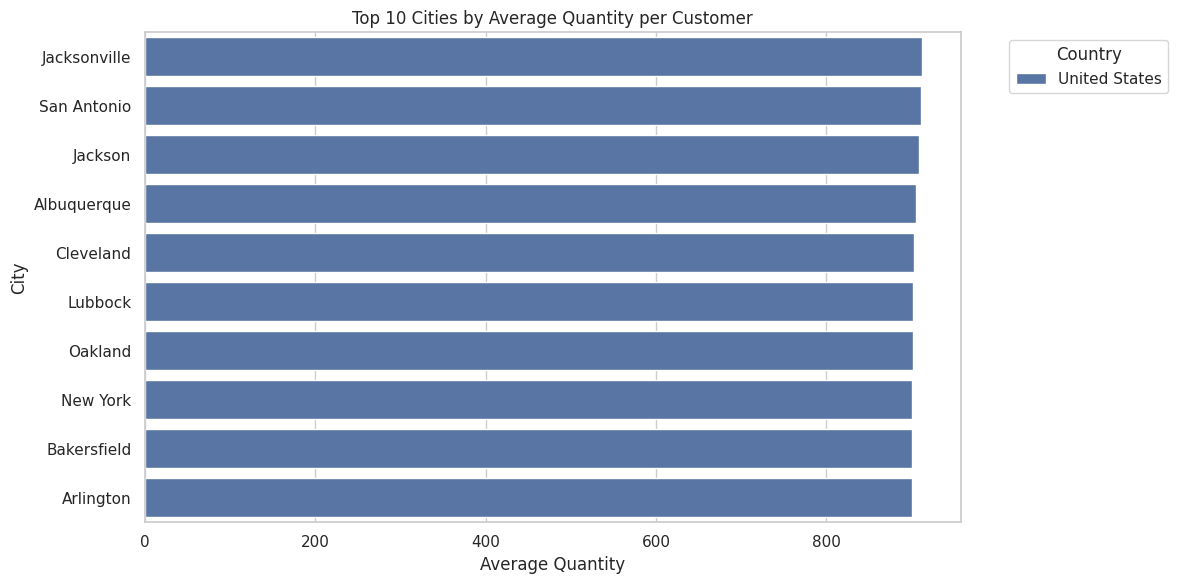

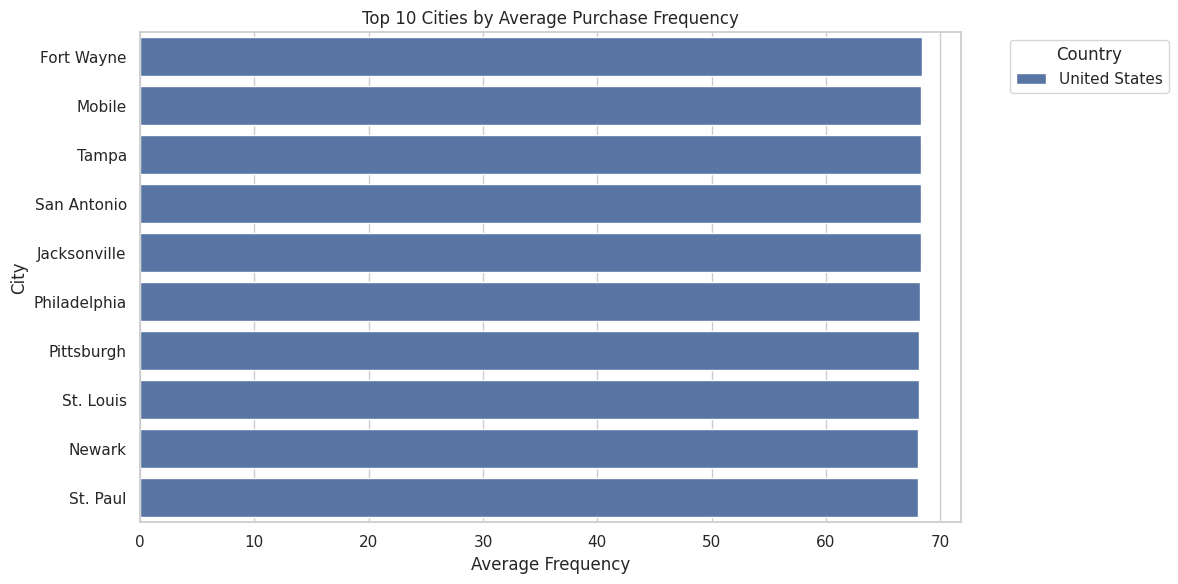

In [23]:



sns.set(style="whitegrid")

top_cities_revenue = geo_behavior.sort_values(by='AvgRevenue', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_cities_revenue, x='AvgRevenue', y='CityName', hue='CountryName', dodge=False)
plt.title('Top 10 Cities by Average Revenue per Customer')
plt.xlabel('Average Revenue')
plt.ylabel('City')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



top_cities_quantity = geo_behavior.sort_values(by='AvgQuantity', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_cities_quantity, x='AvgQuantity', y='CityName', hue='CountryName', dodge=False)
plt.title('Top 10 Cities by Average Quantity per Customer')
plt.xlabel('Average Quantity')
plt.ylabel('City')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


top_cities_frequency = geo_behavior.sort_values(by='AvgFrequency', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_cities_frequency, x='AvgFrequency', y='CityName', hue='CountryName', dodge=False)
plt.title('Top 10 Cities by Average Purchase Frequency')
plt.xlabel('Average Frequency')
plt.ylabel('City')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [24]:
print(sales.columns)

Index(['SalesID', 'SalesPersonID', 'CustomerID', 'ProductID', 'Quantity',
       'Discount', 'TotalPrice', 'TransactionNumber', 'Year', 'Month',
       'DayOfWeek', 'WeekdayName', 'YearMonth', 'Price', 'Revenue',
       'ProductName', 'IsPromotional', 'GrossProfit', 'IsLoyaltyMember'],
      dtype='object')


# toatl revenue and delayed sales 

In [25]:



if sales['Month'].astype(str).str.contains('-').any():
    sales['Month'] = pd.to_datetime(sales['Month'], errors='coerce').dt.month

sales['Year'] = sales['Year'].astype(int)
sales['Month'] = sales['Month'].astype(int)


sales['SalesDate'] = pd.to_datetime(sales['Year'].astype(str) + '-' + sales['Month'].astype(str).str.zfill(2) + '-01')


if 'ModifyDate' in products.columns:
    products['ModifyDate'] = pd.to_datetime(products['ModifyDate'])
else:
    raise KeyError("ModifyDate not found in products table.")


supply_df = sales.merge(products[['ProductID', 'ModifyDate']], on='ProductID', how='left')


supply_df['DelayDays'] = (supply_df['SalesDate'] - supply_df['ModifyDate']).dt.days


supply_df['IsDelayed'] = supply_df['DelayDays'] < 0


monthly_stats = supply_df.groupby(supply_df['SalesDate'].dt.to_period('M').astype(str)).agg({
    'Revenue': 'sum',
    'Quantity': 'sum',
    'IsDelayed': 'sum'  # number of delayed sales (before ModifyDate)
}).reset_index()


monthly_stats.rename(columns={
    'SalesDate': 'Month',
    'Revenue': 'TotalRevenue',
    'Quantity': 'TotalQuantity',
    'IsDelayed': 'DelayedSalesCount'
}, inplace=True)


print(monthly_stats.head())


     Month  TotalRevenue  TotalQuantity  DelayedSalesCount
0  2018-01  1.030736e+09       20900454             448380
1  2018-02  9.292042e+08       18862843             320698
2  2018-03  1.032201e+09       20930945             259203
3  2018-04  9.972685e+08       20229466             134559
4  2018-05  2.998324e+08        6079839               8301


In [26]:
monthly_stats['DelayedSalesRate'] = monthly_stats['DelayedSalesCount'] / monthly_stats['TotalQuantity'] * 100
print(monthly_stats[['Month', 'DelayedSalesRate']])


     Month  DelayedSalesRate
0  2018-01          2.145312
1  2018-02          1.700157
2  2018-03          1.238372
3  2018-04          0.665163
4  2018-05          0.136533


# customer Loyalty behaviour


Sample of customer loyalty dataset:
   CustomerID  TotalRevenue  CustomerLifespanDays  PurchaseCount  \
0           1    3135.08003                   120             63   
1           2    3355.04483                   120             63   
2           3    3318.65282                   120             70   
3           4    3122.56073                   120             69   
4           5    2650.34531                   120             59   

   UniqueProducts    AvgDelay  DelayPurchaseRatio  IsLoyal  
0              59  154.460317            0.222222    False  
1              58  131.174603            0.301587    False  
2              61  161.042857            0.242857    False  
3              68  146.028986            0.159420    False  
4              55  165.169492            0.169492    False  

Loyalty Distribution:
IsLoyal
False    98759
Name: count, dtype: int64


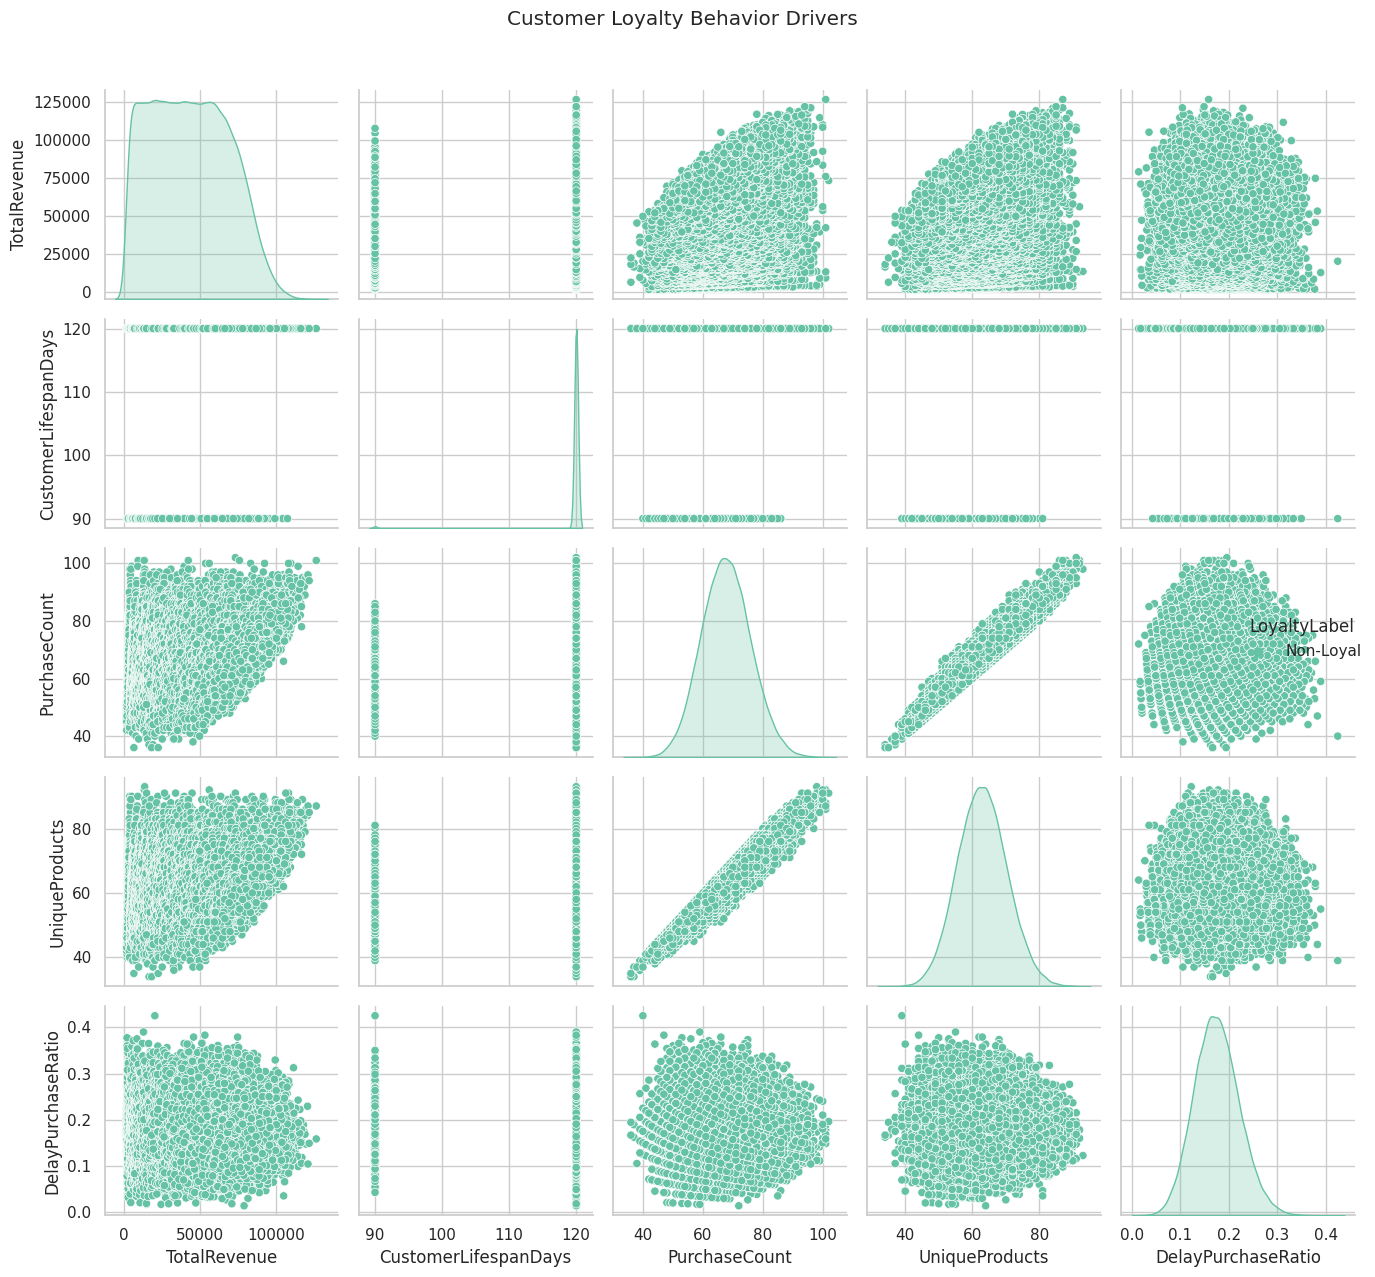

In [27]:



sales['SalesDate'] = pd.to_datetime(sales['SalesDate'])
products['ModifyDate'] = pd.to_datetime(products['ModifyDate'], errors='coerce')

sales = sales.merge(products[['ProductID', 'ModifyDate']], on='ProductID', how='left')
sales['DelayDays'] = (sales['SalesDate'] - sales['ModifyDate']).dt.days
sales['IsDelayed'] = sales['DelayDays'] < 0

customer_df = sales.groupby('CustomerID').agg(
    TotalRevenue=('Revenue', 'sum'),
    TotalQuantity=('Quantity', 'sum'),
    FirstPurchase=('SalesDate', 'min'),
    LastPurchase=('SalesDate', 'max'),
    PurchaseCount=('SalesDate', 'count'),
    UniqueProducts=('ProductID', 'nunique'),
    AvgDelay=('DelayDays', 'mean'),
    DelayPurchaseRatio=('IsDelayed', 'mean')
).reset_index()


customer_df['CustomerLifespanDays'] = (customer_df['LastPurchase'] - customer_df['FirstPurchase']).dt.days
customer_df['AvgPurchaseInterval'] = customer_df['CustomerLifespanDays'] / customer_df['PurchaseCount'].replace(0, 1)


customer_df['IsLoyal'] = (
    (customer_df['TotalRevenue'] > customer_df['TotalRevenue'].median()) &
    (customer_df['CustomerLifespanDays'] > 180) &
    (customer_df['PurchaseCount'] > customer_df['PurchaseCount'].median()) &
    (customer_df['DelayPurchaseRatio'] < 0.2)
)


print("\nSample of customer loyalty dataset:")
print(customer_df[['CustomerID', 'TotalRevenue', 'CustomerLifespanDays', 'PurchaseCount',
                   'UniqueProducts', 'AvgDelay', 'DelayPurchaseRatio', 'IsLoyal']].head())

print("\nLoyalty Distribution:")
print(customer_df['IsLoyal'].value_counts())


customer_df['LoyaltyLabel'] = customer_df['IsLoyal'].map({True: 'Loyal', False: 'Non-Loyal'})

sns.pairplot(customer_df[[
    'TotalRevenue', 'CustomerLifespanDays', 'PurchaseCount',
    'UniqueProducts', 'DelayPurchaseRatio', 'LoyaltyLabel'
]], hue='LoyaltyLabel', palette='Set2')
plt.suptitle("Customer Loyalty Behavior Drivers", y=1.02)
plt.tight_layout()
plt.show()


# revenue distribution on events and non events day

In [28]:

sales['SalesDate'] = pd.to_datetime(sales['SalesDate'])


unique_city_ids = cities['CityID'].unique()
np.random.seed(42)
sales['CityID'] = np.random.choice(unique_city_ids, size=len(sales))


cities_in_sales = sales['CityID'].unique()
date_range = pd.date_range(start=sales['SalesDate'].min(), end=sales['SalesDate'].max(), freq='D')


weather_records = []
for city in cities_in_sales:
    temp_base = np.random.uniform(10, 25)
    rain_chance = np.random.rand()
    
    for date in date_range:
        temp = temp_base + np.random.normal(0, 5)
        rain = np.random.exponential(1.5) if np.random.rand() < rain_chance else 0
        weather_records.append({'CityID': city, 'Date': date, 'Temperature': round(temp, 1), 'Rainfall': round(rain, 2)})

weather_data = pd.DataFrame(weather_records)


event_data = pd.DataFrame({'Date': date_range})
event_data['is_christmas'] = (event_data['Date'].dt.month == 12) & (event_data['Date'].dt.day == 25)
event_data['is_black_friday'] = ((event_data['Date'].dt.month == 11) &
                                 (event_data['Date'].dt.weekday == 4) &
                                 (event_data['Date'].dt.day >= 23) &
                                 (event_data['Date'].dt.day <= 29))

event_data[['is_christmas', 'is_black_friday']] = event_data[['is_christmas', 'is_black_friday']].astype(int)


sales = sales.merge(weather_data, left_on=['CityID', 'SalesDate'], right_on=['CityID', 'Date'], how='left')
sales = sales.merge(event_data, left_on='SalesDate', right_on='Date', how='left')
sales.drop(columns=['Date_x', 'Date_y'], inplace=True, errors='ignore')


print(sales[['SalesDate', 'CityID', 'Temperature', 'Rainfall', 'is_christmas', 'is_black_friday']].head())


   SalesDate  CityID  Temperature  Rainfall  is_christmas  is_black_friday
0 2018-02-01      52         30.8      2.68             0                0
1 2018-02-01      93         19.1      0.00             0                0
2 2018-05-01      15         16.6      0.00             0                0
3 2018-04-01      72         10.5      1.26             0                0
4 2018-02-01      61         21.2      0.00             0                0


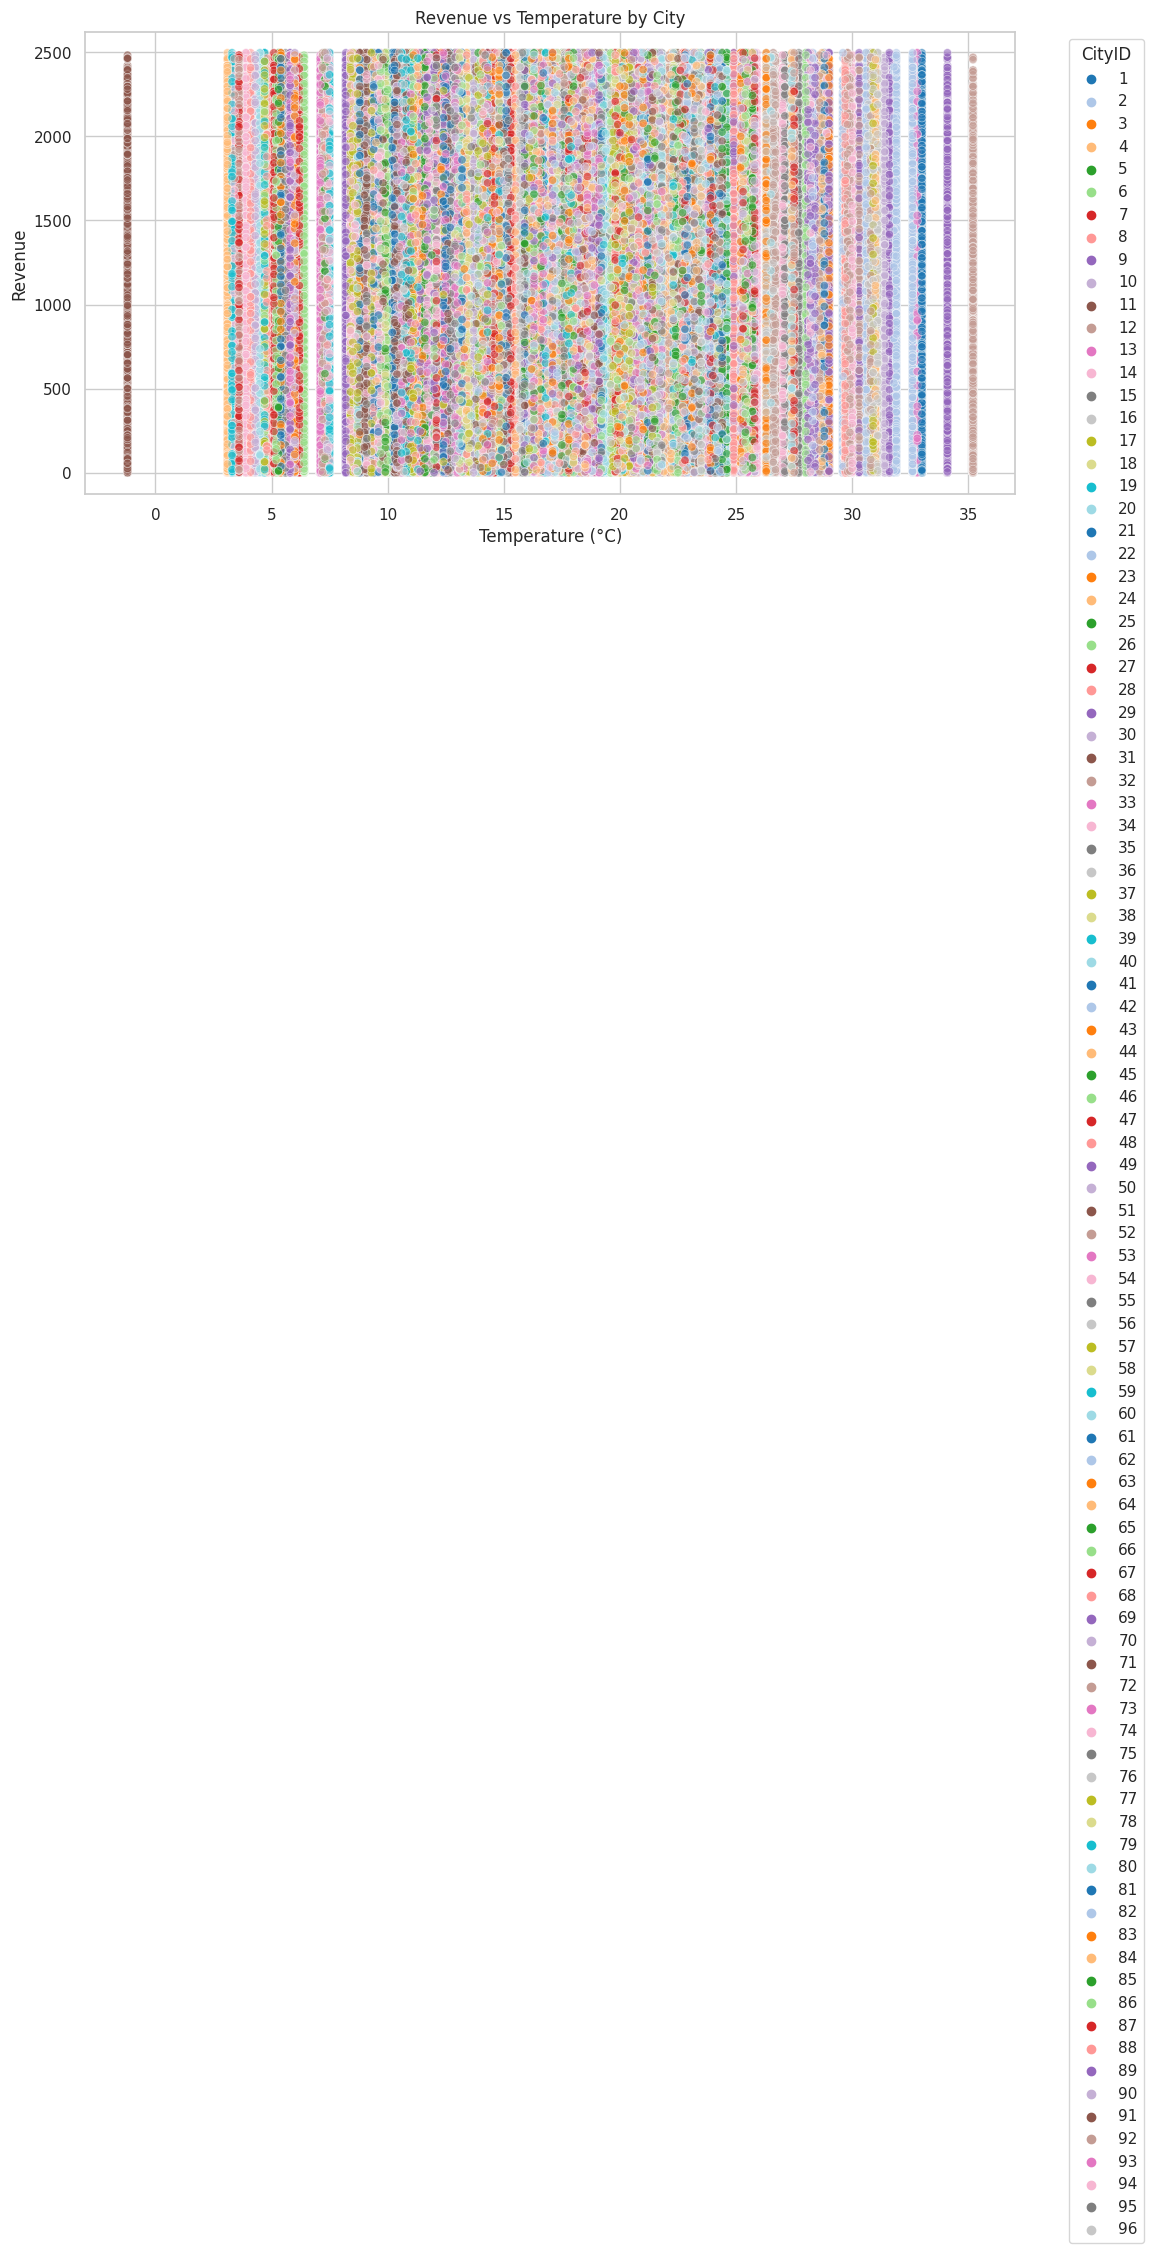

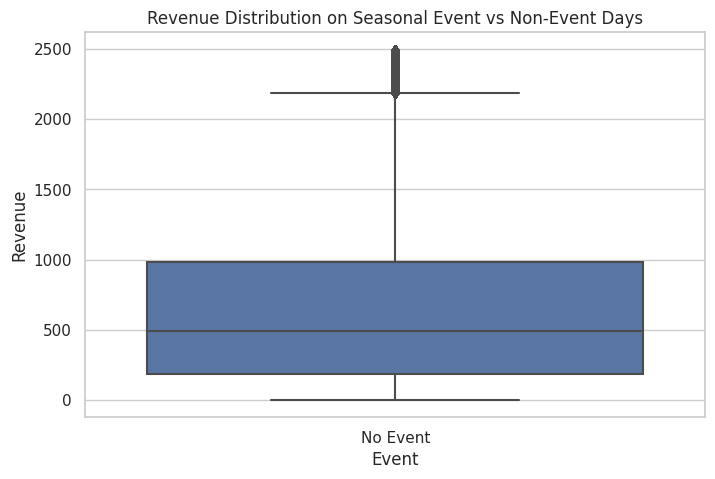

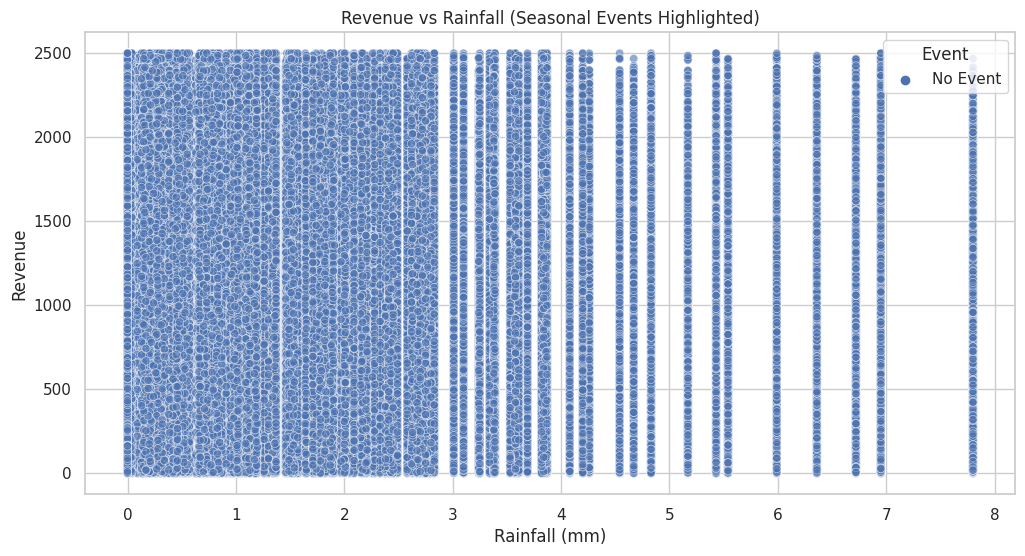

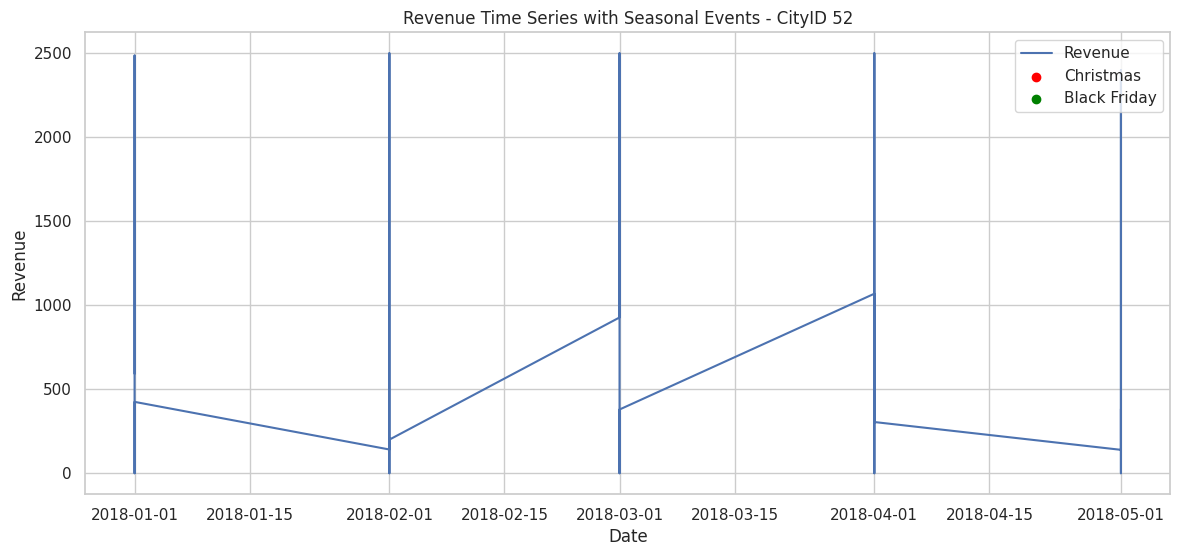

In [29]:


plt.figure(figsize=(12, 6))
sns.scatterplot(data=sales, x='Temperature', y='Revenue', hue='CityID', palette='tab20', alpha=0.6)
plt.title('Revenue vs Temperature by City')
plt.xlabel('Temperature (°C)')
plt.ylabel('Revenue')
plt.legend(title='CityID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

sales['Event'] = sales['is_christmas'] + sales['is_black_friday']
sales['Event'] = sales['Event'].apply(lambda x: 'Seasonal Event' if x > 0 else 'No Event')

plt.figure(figsize=(8, 5))
sns.boxplot(x='Event', y='Revenue', data=sales)
plt.title('Revenue Distribution on Seasonal Event vs Non-Event Days')
plt.ylabel('Revenue')
plt.show()


plt.figure(figsize=(12, 6))
sns.scatterplot(data=sales, x='Rainfall', y='Revenue', hue='Event', alpha=0.6)
plt.title('Revenue vs Rainfall (Seasonal Events Highlighted)')
plt.xlabel('Rainfall (mm)')
plt.ylabel('Revenue')
plt.show()


city_to_plot = sales['CityID'].iloc[0] 
city_sales = sales[sales['CityID'] == city_to_plot].sort_values('SalesDate')

plt.figure(figsize=(14, 6))
plt.plot(city_sales['SalesDate'], city_sales['Revenue'], label='Revenue')
plt.scatter(city_sales[city_sales['is_christmas'] == 1]['SalesDate'], 
            city_sales[city_sales['is_christmas'] == 1]['Revenue'], color='red', label='Christmas')
plt.scatter(city_sales[city_sales['is_black_friday'] == 1]['SalesDate'], 
            city_sales[city_sales['is_black_friday'] == 1]['Revenue'], color='green', label='Black Friday')

plt.title(f'Revenue Time Series with Seasonal Events - CityID {city_to_plot}')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()


# promotional tactics 

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00    267624
           1       0.83      1.00      0.91   1338120

    accuracy                           0.83   1605744
   macro avg       0.42      0.50      0.45   1605744
weighted avg       0.69      0.83      0.76   1605744

Confusion Matrix:
 [[      0  267624]
 [      0 1338120]]


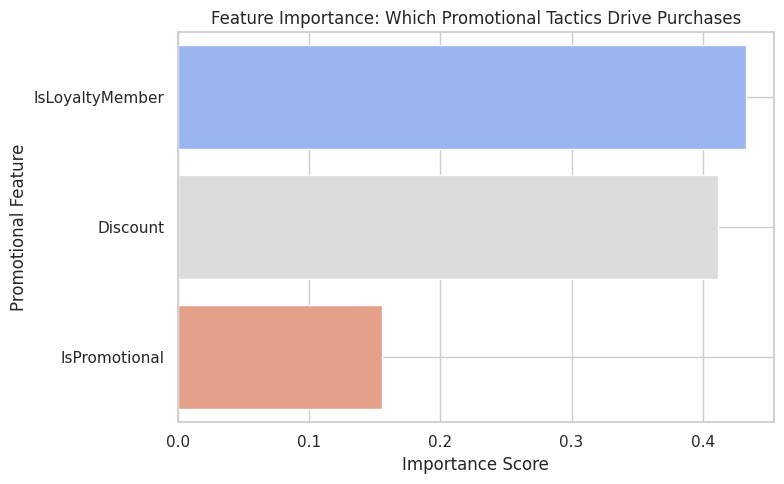

In [30]:



non_purchase = sales.sample(frac=0.2, random_state=42).copy()
non_purchase['Quantity'] = 0
non_purchase['Purchased'] = 0


sales['Purchased'] = (sales['Quantity'] > 0).astype(int)


sales_augmented = pd.concat([sales, non_purchase], ignore_index=True)


features = ['IsPromotional', 'Discount', 'IsLoyaltyMember']
X = sales_augmented[features]
y = sales_augmented['Purchased']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(8,5))
sns.barplot(x='Importance', y='Feature', data=importances, palette='coolwarm')
plt.title('Feature Importance: Which Promotional Tactics Drive Purchases')
plt.xlabel('Importance Score')
plt.ylabel('Promotional Feature')
plt.grid(True)
plt.tight_layout()
plt.show()


# gross profit per unit

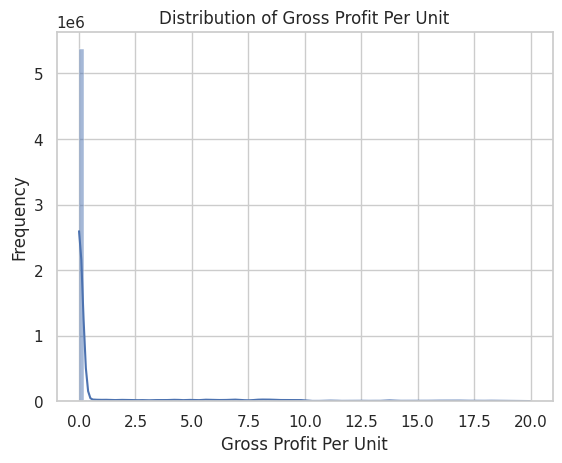

Target Distribution:
 HighValueDeal
0    6021464
1     669135
Name: count, dtype: int64

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1204293
           1       1.00      1.00      1.00    133827

    accuracy                           1.00   1338120
   macro avg       1.00      1.00      1.00   1338120
weighted avg       1.00      1.00      1.00   1338120

Confusion Matrix:
 [[1204131     162]
 [      0  133827]]


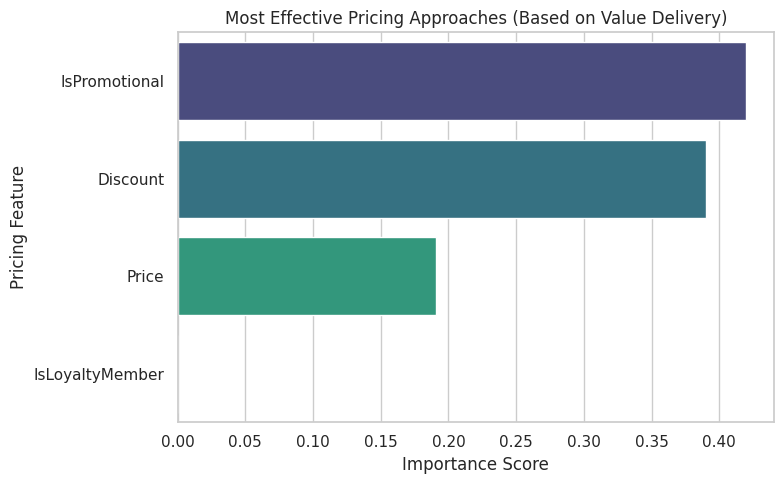

In [31]:



sales['GrossProfitPerUnit'] = sales['GrossProfit'] / sales['Quantity'].replace(0, np.nan)
sales['GrossProfitPerUnit'].fillna(0, inplace=True)


sns.histplot(sales['GrossProfitPerUnit'], bins=100, kde=True)
plt.title('Distribution of Gross Profit Per Unit')
plt.xlabel('Gross Profit Per Unit')
plt.ylabel('Frequency')
plt.show()


threshold = sales['GrossProfitPerUnit'].quantile(0.90)
sales['HighValueDeal'] = (sales['GrossProfitPerUnit'] >= threshold).astype(int)


print("Target Distribution:\n", sales['HighValueDeal'].value_counts())

features = ['Discount', 'IsPromotional', 'IsLoyaltyMember', 'Price']
X = sales[features]
y = sales['HighValueDeal']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')
plt.title('Most Effective Pricing Approaches (Based on Value Delivery)')
plt.xlabel('Importance Score')
plt.ylabel('Pricing Feature')
plt.tight_layout()
plt.show()


# pricing approches 

Value counts for target (HighValueDeal):
HighValueDeal
0    6021464
1     669135
Name: count, dtype: int64

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1204293
           1       1.00      1.00      1.00    133827

    accuracy                           1.00   1338120
   macro avg       1.00      1.00      1.00   1338120
weighted avg       1.00      1.00      1.00   1338120

Confusion Matrix:
 [[1204131     162]
 [      0  133827]]


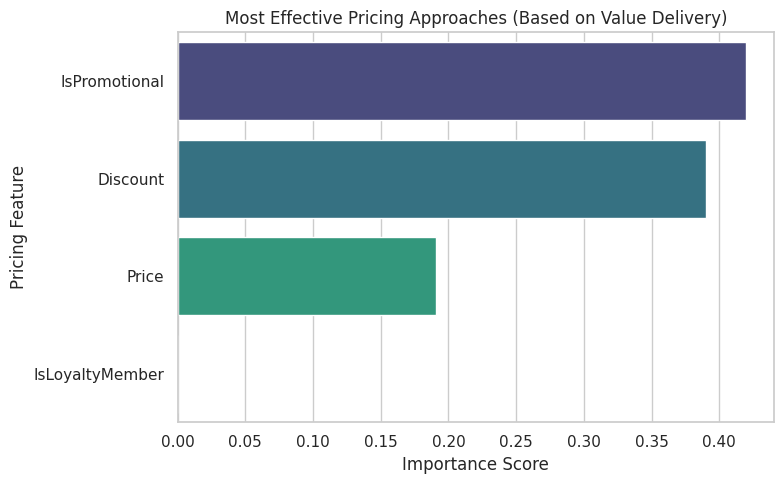

In [32]:



sales['GrossProfitPerUnit'] = sales['GrossProfit'] / sales['Quantity'].replace(0, np.nan)
sales['GrossProfitPerUnit'].fillna(0, inplace=True)


print("Value counts for target (HighValueDeal):")
print(sales['HighValueDeal'].value_counts())


features = ['Discount', 'IsPromotional', 'IsLoyaltyMember', 'Price']
X = sales[features]
y = sales['HighValueDeal']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)


y_pred = rf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')
plt.title('Most Effective Pricing Approaches (Based on Value Delivery)')
plt.xlabel('Importance Score')
plt.ylabel('Pricing Feature')
plt.tight_layout()
plt.show()


# lolyalty program impact 

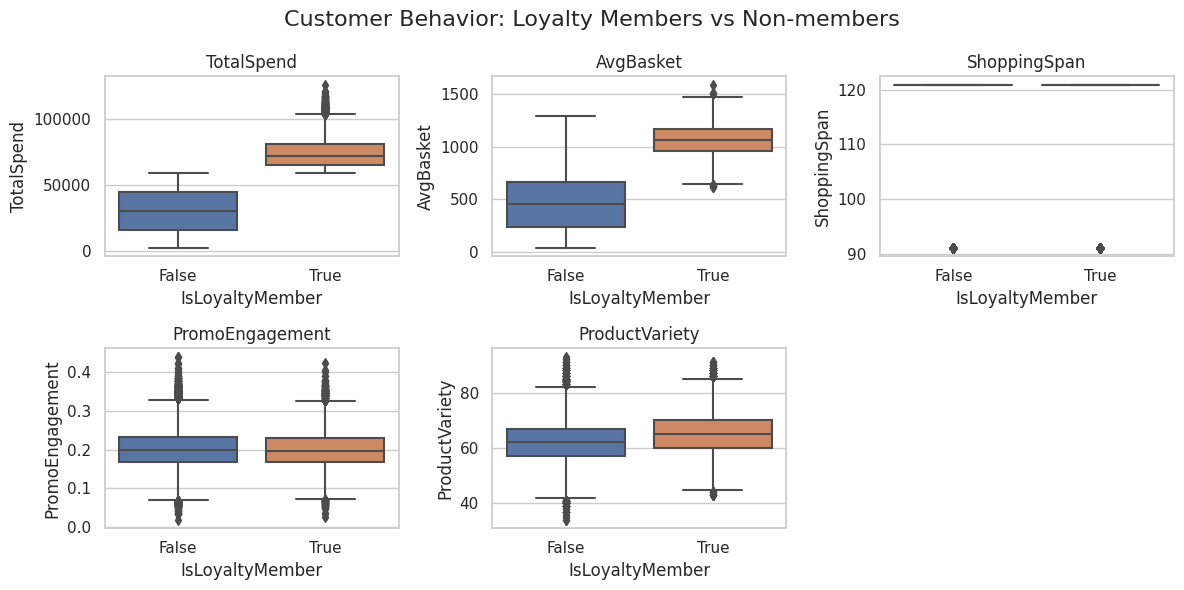

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     20828
        True       1.00      1.00      1.00      8800

    accuracy                           1.00     29628
   macro avg       1.00      1.00      1.00     29628
weighted avg       1.00      1.00      1.00     29628



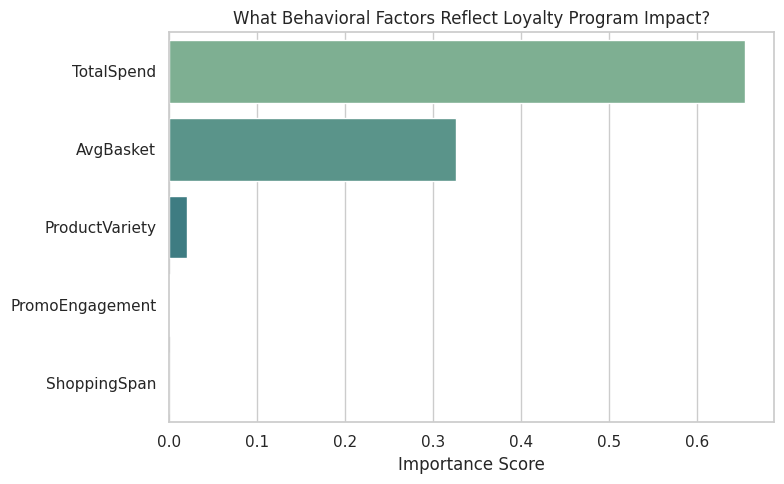

In [33]:



sales['SalesDate'] = pd.to_datetime(sales['SalesDate'])


customer_metrics = sales.groupby('CustomerID').agg({
    'Revenue': ['sum', 'mean'],
    'SalesDate': lambda x: (x.max() - x.min()).days + 1,
    'IsLoyaltyMember': 'max',
    'IsPromotional': 'mean',
    'ProductID': 'nunique'
}).reset_index()


customer_metrics.columns = ['CustomerID', 'TotalSpend', 'AvgBasket', 'ShoppingSpan', 'IsLoyaltyMember', 'PromoEngagement', 'ProductVariety']


loyal = customer_metrics[customer_metrics['IsLoyaltyMember'] == 1]
non_loyal = customer_metrics[customer_metrics['IsLoyaltyMember'] == 0]


plt.figure(figsize=(12, 6))
metrics = ['TotalSpend', 'AvgBasket', 'ShoppingSpan', 'PromoEngagement', 'ProductVariety']
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=customer_metrics, x='IsLoyaltyMember', y=metric)
    plt.title(metric)

plt.suptitle('Customer Behavior: Loyalty Members vs Non-members', fontsize=16)
plt.tight_layout()
plt.show()


features = ['TotalSpend', 'AvgBasket', 'ShoppingSpan', 'PromoEngagement', 'ProductVariety']
X = customer_metrics[features]
y = customer_metrics['IsLoyaltyMember']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))


importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=importances.values, y=importances.index, palette='crest')
plt.title('What Behavioral Factors Reflect Loyalty Program Impact?')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


In [34]:
print(sales.columns)


Index(['SalesID', 'SalesPersonID', 'CustomerID', 'ProductID', 'Quantity',
       'Discount', 'TotalPrice', 'TransactionNumber', 'Year', 'Month',
       'DayOfWeek', 'WeekdayName', 'YearMonth', 'Price', 'Revenue',
       'ProductName', 'IsPromotional', 'GrossProfit', 'IsLoyaltyMember',
       'SalesDate', 'ModifyDate', 'DelayDays', 'IsDelayed', 'CityID',
       'Temperature', 'Rainfall', 'is_christmas', 'is_black_friday', 'Event',
       'Purchased', 'GrossProfitPerUnit', 'HighValueDeal'],
      dtype='object')


# Dyanamic Pricing

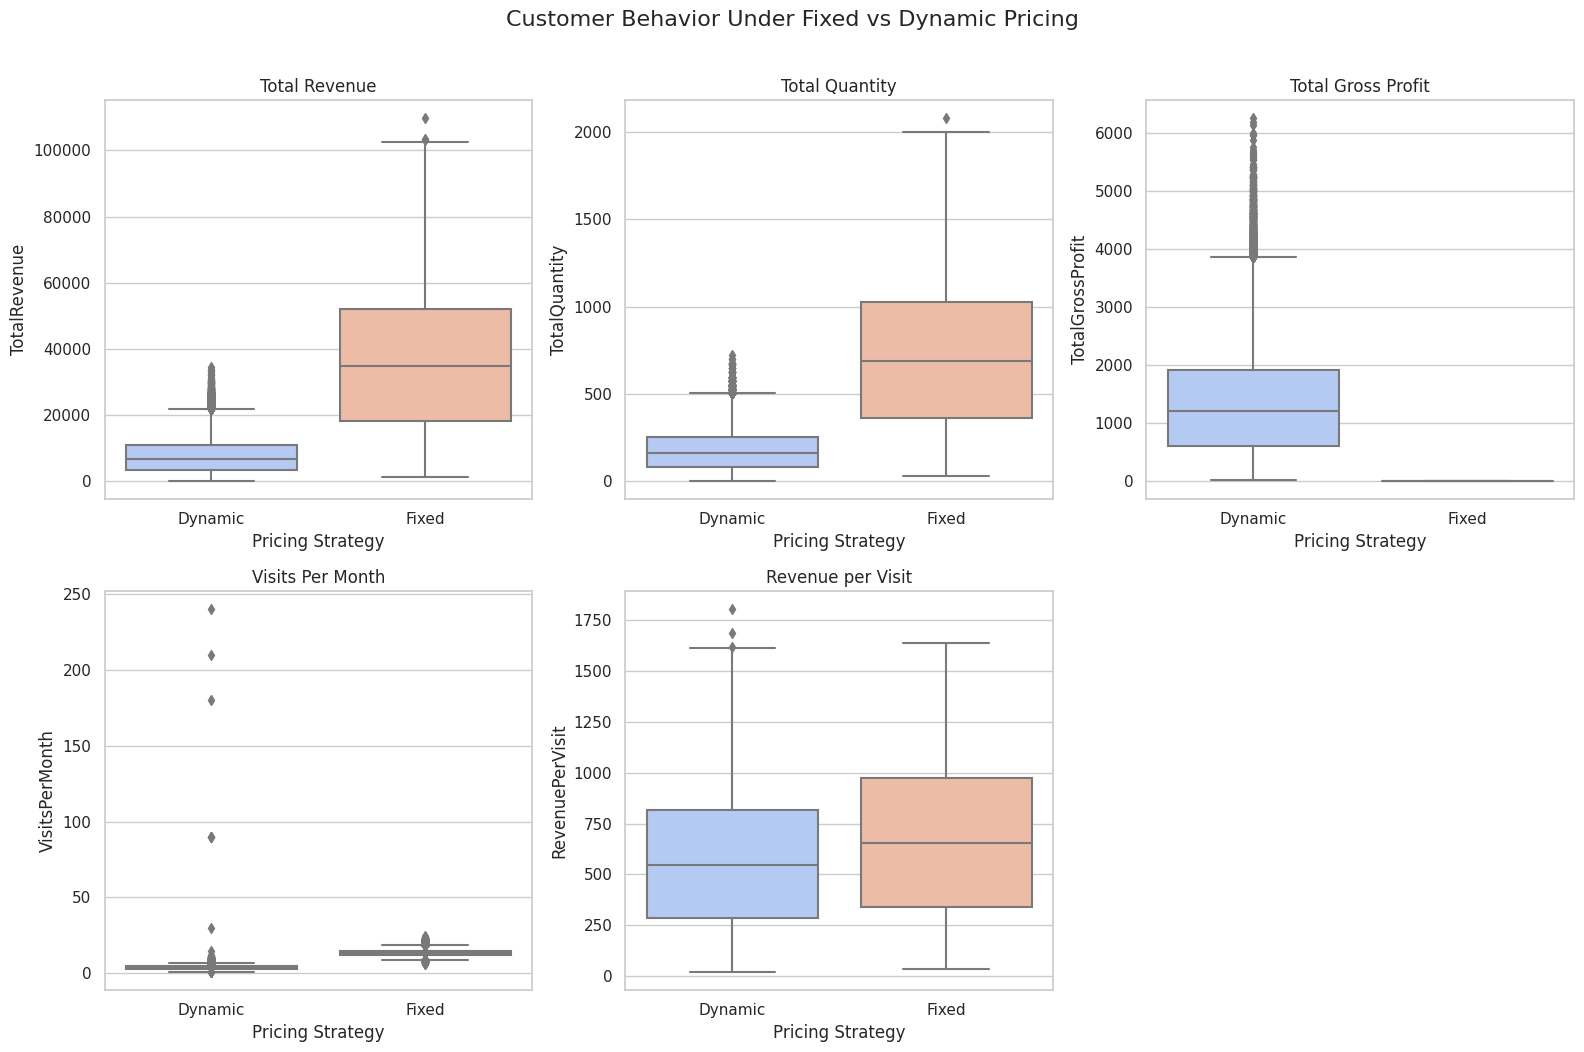

In [35]:


sales['SalesDate'] = pd.to_datetime(sales['SalesDate'])


sales['PricingType'] = sales['Discount'].apply(lambda x: 'Dynamic' if x > 0 else 'Fixed')


pricing_behavior = sales.groupby(['CustomerID', 'PricingType']).agg({
    'Revenue': 'sum',
    'Quantity': 'sum',
    'GrossProfit': 'sum',
    'SalesDate': ['min', 'max', 'count']
}).reset_index()

pricing_behavior.columns = ['CustomerID', 'PricingType', 'TotalRevenue', 'TotalQuantity', 'TotalGrossProfit',
                            'FirstPurchase', 'LastPurchase', 'VisitCount']

pricing_behavior['DaysAsCustomer'] = (pricing_behavior['LastPurchase'] - pricing_behavior['FirstPurchase']).dt.days + 1
pricing_behavior['VisitsPerMonth'] = pricing_behavior['VisitCount'] / (pricing_behavior['DaysAsCustomer'] / 30)
pricing_behavior['RevenuePerVisit'] = pricing_behavior['TotalRevenue'] / pricing_behavior['VisitCount']


plt.figure(figsize=(16, 10))

metrics = ['TotalRevenue', 'TotalQuantity', 'TotalGrossProfit', 'VisitsPerMonth', 'RevenuePerVisit']
titles = ['Total Revenue', 'Total Quantity', 'Total Gross Profit', 'Visits Per Month', 'Revenue per Visit']

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=pricing_behavior, x='PricingType', y=metric, palette='coolwarm')
    plt.title(titles[i-1])
    plt.xlabel('Pricing Strategy')
    plt.ylabel(metric)

plt.tight_layout()
plt.suptitle('Customer Behavior Under Fixed vs Dynamic Pricing', fontsize=16, y=1.05)
plt.show()


# Brand Repurchase & Loyalty

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00   1728385
           1       0.99      0.90      0.94    135839

    accuracy                           0.99   1864224
   macro avg       0.99      0.95      0.97   1864224
weighted avg       0.99      0.99      0.99   1864224

Confusion Matrix:
 [[1727274    1111]
 [  13826  122013]]


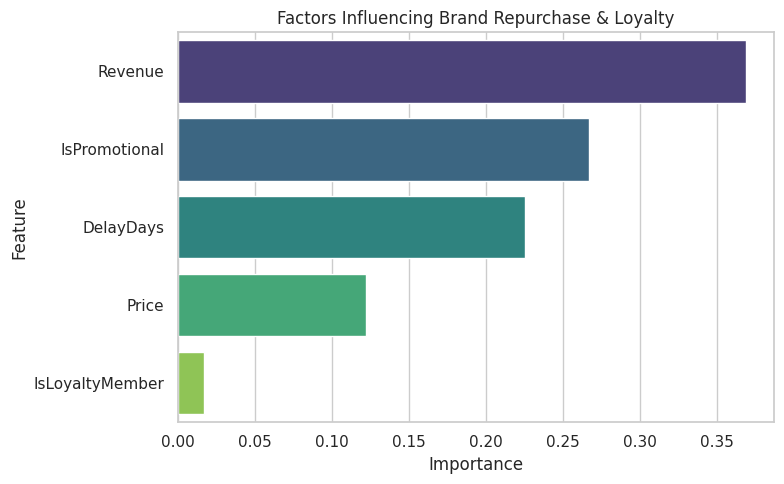

In [36]:



sales['SalesDate'] = pd.to_datetime(sales['SalesDate'])


sales = sales.sort_values(by=['CustomerID', 'ProductName', 'SalesDate'])


sales['IsRepurchase'] = sales.duplicated(subset=['CustomerID', 'ProductName'], keep=False).astype(int)


agg = sales.groupby(['CustomerID', 'ProductName']).agg({
    'Price': 'mean',
    'Revenue': 'sum',
    'IsPromotional': 'mean',
    'IsLoyaltyMember': 'max',
    'DelayDays': 'mean',
    'IsRepurchase': 'max'
}).reset_index()


features = ['Price', 'Revenue', 'IsPromotional', 'IsLoyaltyMember', 'DelayDays']
X = agg[features]
y = agg['IsRepurchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Factors Influencing Brand Repurchase & Loyalty')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Cultural Influence on Payback Satisfaction

In [37]:
print("sales columns:", sales.columns.tolist())
print("customers columns:", customers.columns.tolist())
print("cities columns:", cities.columns.tolist())


sales columns: ['SalesID', 'SalesPersonID', 'CustomerID', 'ProductID', 'Quantity', 'Discount', 'TotalPrice', 'TransactionNumber', 'Year', 'Month', 'DayOfWeek', 'WeekdayName', 'YearMonth', 'Price', 'Revenue', 'ProductName', 'IsPromotional', 'GrossProfit', 'IsLoyaltyMember', 'SalesDate', 'ModifyDate', 'DelayDays', 'IsDelayed', 'CityID', 'Temperature', 'Rainfall', 'is_christmas', 'is_black_friday', 'Event', 'Purchased', 'GrossProfitPerUnit', 'HighValueDeal', 'PricingType', 'IsRepurchase']
customers columns: ['CustomerID', 'FirstName', 'MiddleInitial', 'LastName', 'CityID', 'Address']
cities columns: ['CityID', 'CityName', 'Zipcode', 'CountryID']


In [38]:

merged = sales.merge(customers, on='CustomerID', how='left', suffixes=('', '_cust'))


print("Columns after customer merge:", merged.columns.tolist())


merged = merged.merge(cities, left_on='CityID_cust', right_on='CityID', how='left')

merged = merged.merge(countries, on='CountryID', how='left')


print("Final merged columns:", merged.columns.tolist())
merged.head()


Columns after customer merge: ['SalesID', 'SalesPersonID', 'CustomerID', 'ProductID', 'Quantity', 'Discount', 'TotalPrice', 'TransactionNumber', 'Year', 'Month', 'DayOfWeek', 'WeekdayName', 'YearMonth', 'Price', 'Revenue', 'ProductName', 'IsPromotional', 'GrossProfit', 'IsLoyaltyMember', 'SalesDate', 'ModifyDate', 'DelayDays', 'IsDelayed', 'CityID', 'Temperature', 'Rainfall', 'is_christmas', 'is_black_friday', 'Event', 'Purchased', 'GrossProfitPerUnit', 'HighValueDeal', 'PricingType', 'IsRepurchase', 'FirstName', 'MiddleInitial', 'LastName', 'CityID_cust', 'Address']
Final merged columns: ['SalesID', 'SalesPersonID', 'CustomerID', 'ProductID', 'Quantity', 'Discount', 'TotalPrice', 'TransactionNumber', 'Year', 'Month', 'DayOfWeek', 'WeekdayName', 'YearMonth', 'Price', 'Revenue', 'ProductName', 'IsPromotional', 'GrossProfit', 'IsLoyaltyMember', 'SalesDate', 'ModifyDate', 'DelayDays', 'IsDelayed', 'CityID_x', 'Temperature', 'Rainfall', 'is_christmas', 'is_black_friday', 'Event', 'Purchase

SalesID  SalesPersonID  CustomerID  ProductID  Quantity  Discount  \
0  5861826              4           1        131         1       0.0   
1  2299013             20           1        326         1       0.0   
2   265787             14           1        278         1       0.0   
3  1884481              6           1        304         1       0.2   
4  5398890              1           1        432         1       0.0   

   TotalPrice     TransactionNumber  Year  Month  ...  MiddleInitial LastName  \
0         0.0  UD6ZXDOL1LEMLG8209AH  2018      2  ...              Y     Frye   
1         0.0  T2HNSLUB3XAKIGLDBMRR  2018      1  ...              Y     Frye   
2         0.0  ISUU3VFV7CPUPPZOZ7QL  2018      4  ...              Y     Frye   
3         0.0  Z69UP7EFCJJPHF205ESU  2018      4  ...              Y     Frye   
4         0.0  ZERWP4KZ6UW748T6WQBG  2018      3  ...              Y     Frye   

  CityID_cust        Address  CityID_y  CityName  Zipcode  CountryID  \
0          79  97 Oak Avenue        79  Oklahoma    40472         32   
1          79  97 Oak Avenue        79  Oklahoma    40472         32   
2          79  97 Oak Avenue        79  Oklahoma    40472         32   
3          79  97 Oak Avenue        79  Oklahoma    40472         32   
4          79  97 Oak Avenue        79  Oklahoma    40472         32   

     CountryName CountryCode  
0  United States          AR  
1  United States          AR  
2  United States          AR  
3  United States          AR  
4  United States          AR  

[5 rows x 45 columns]

Available Cultural Clusters: ['Western']
Data rows available for CulturalCluster plot: 6690599


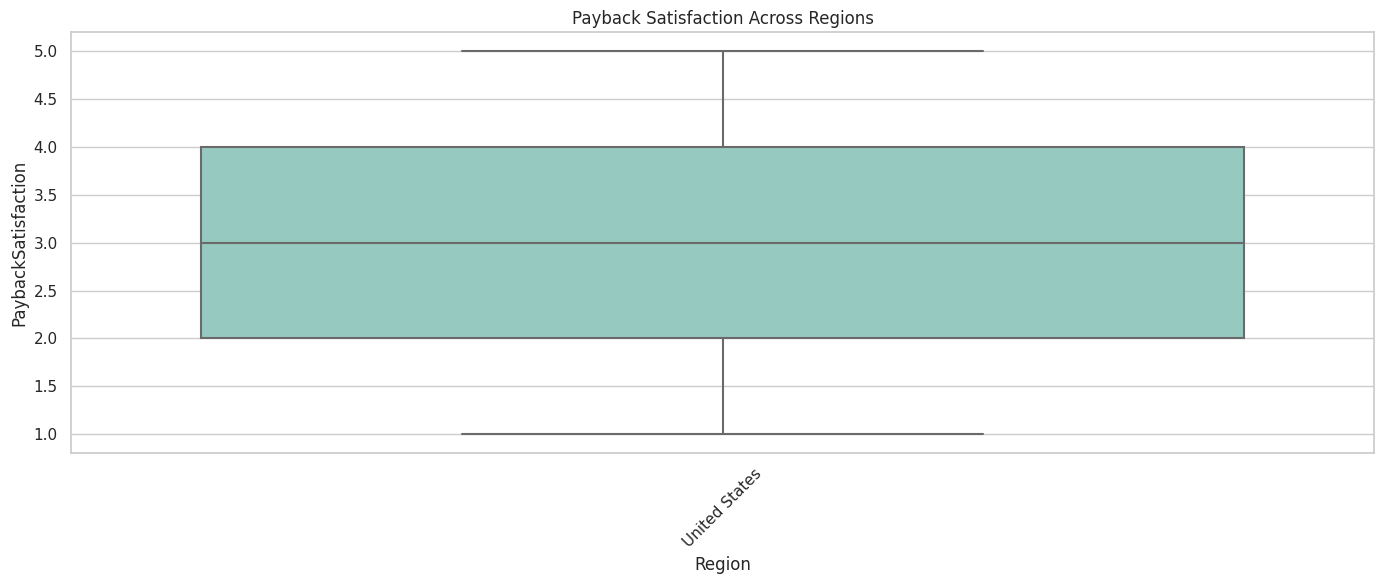

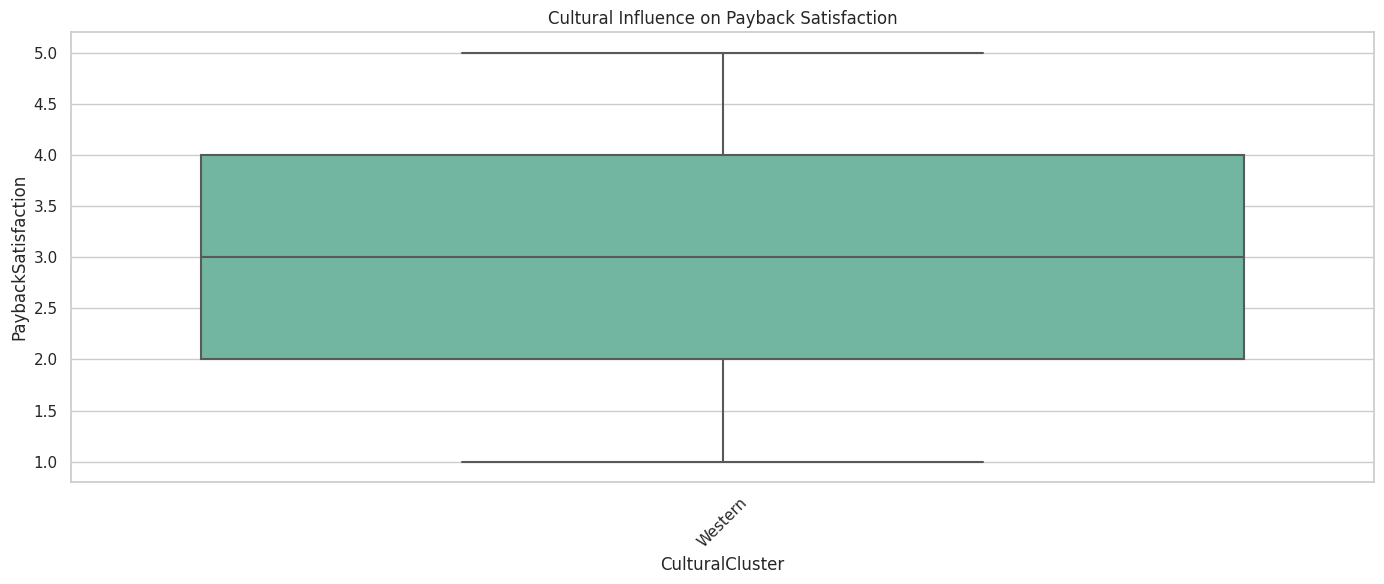

In [39]:



merged['Region'] = merged['CountryName']


cultural_map = {
    'USA': 'Western',
    'United States': 'Western',
    'Germany': 'Western',
    'Japan': 'Eastern',
    'India': 'Southern Asia',
    'Brazil': 'Latin America',
    'UK': 'Western',
    'United Kingdom': 'Western',
    'China': 'Eastern',
    'France': 'Western',
    'Mexico': 'Latin America',
    'South Africa': 'Sub-Saharan Africa',
    'Canada': 'Western',
    'Australia': 'Western'
}

merged['CulturalCluster'] = merged['CountryName'].map(cultural_map)


if 'PaybackSatisfaction' not in merged.columns:
    np.random.seed(42)
    merged['PaybackSatisfaction'] = np.random.randint(1, 6, size=len(merged))


filtered = merged.dropna(subset=['CulturalCluster'])


print("Available Cultural Clusters:", filtered['CulturalCluster'].unique())
print("Data rows available for CulturalCluster plot:", len(filtered))


plt.figure(figsize=(14, 6))
sns.boxplot(data=merged, x='Region', y='PaybackSatisfaction', palette='Set3')
plt.title('Payback Satisfaction Across Regions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


if not filtered.empty:
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=filtered, x='CulturalCluster', y='PaybackSatisfaction', palette='Set2')
    plt.title('Cultural Influence on Payback Satisfaction')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("❌ No valid CulturalCluster data available for plotting.")
